# Proyecto Final - Grupo 1

## Integrantes

* Franco Gaito
* Francisco De Lorenzi
* Julieta Herrera
* Alejandro Relañez
* Cristian Barrera

## Instalaciones

Ejecutar la primera vez y luego comentar

In [1]:
 !pip install arch
 !pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.1 MB/s eta 0:00:00


## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
import pmdarima as pm
import warnings

from typing import List, Dict, Any

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acovf
from statsmodels.tsa.stattools import adfuller, kpss

from arch.unitroot import ZivotAndrews

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Funciones

In [3]:
def dropear_columnas(df_x, columnas):
    """
    Realiza modificaciones en un DataFrame dado, incluyendo eliminación de columnas específicas y
    eliminación de filas con valores NaN en 'fake_positive'.
    """
    df = df_x.copy()
    df = df.drop(columns=columnas, axis=1)
    return df


def fix_types_and_nan(df: pd.DataFrame, config: Dict[str, Dict[str, Any]]) -> pd.DataFrame:
    """
    Función para preprocesar un dataframe según una configuración proporcionada.
    Rellena los valores NA y convierte los tipos de datos. Genera un error si se
    encuentran valores NA en una columna donde 'na_fill_value' está configurado como
    'NOT_ALLOWED'.

    Nota: Devuelve un dataframe que SOLO contiene las columnas especificadas.

    El parámetro config debe ser un diccionario que mapea nombres de columnas a
    otro diccionario que especifica el tipo de dato para la columna ('dtype') y
    cómo manejar los valores NA ('na_fill_value'). Si 'na_fill_value' está
    configurado como 'NOT_ALLOWED', la función generará un ValueError si se
    encuentran valores NA en esa columna.

    Ejemplo:

    config = {
        'promotion_id': {'dtype': str, 'na_fill_value': 'NOT_ALLOWED'},
        'days_of_week': {'dtype': str, 'na_fill_value': 'NOT_ALLOWED'},
        'cap_amount': {'dtype': np.float32, 'na_fill_value': 0},
        'slug': {'dtype': str, 'na_fill_value': 'NOT_ALLOWED'},
        'promotion_banks': {'dtype': str, 'na_fill_value': 'NOT_ALLOWED'},
        'pct_promo_value': {'dtype': np.float32, 'na_fill_value': 0},
        'visibility_start_date': {'dtype': 'datetime64[ns]', 'na_fill_value': 'NOT_ALLOWED'},
        'visibility_stop_date': {'dtype': 'datetime64[ns]', 'na_fill_value': 'NOT_ALLOWED'}
    }

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame de entrada a ser procesado.

    config : dict
        Diccionario que especifica los tipos de datos y el manejo de valores NA para cada columna.

    Returns
    -------
    df : pandas.DataFrame
        Dateframe procesado
    """
    df_copy = df.copy()
    for col, conf in config.items():
        if col in df_copy.columns:
            if conf['na_fill_value'] == "NOT_ALLOWED":
                if df_copy[col].isnull().any():
                    raise ValueError(f"NA valores encontrados en columna {col} que no admite valores NA.")
                df_copy[col] = df_copy[col].astype(conf['dtype'])
            else:
                df_copy[col] = df_copy[col].fillna(conf['na_fill_value']).astype(conf['dtype'])
        else:
            raise KeyError(f"{col} no encontrado en dataframe.")

    return df_copy[list(config.keys())]


def plot_acf_pacf(df, title='FAS y FACP de la Serie Diferenciada'):
    # Set up the plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)

    # Plot ACF and PACF
    plot_acf(df, ax=axes[0], title='FAS')
    plot_pacf(df, ax=axes[1], title='FACP')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def plot_fac(df, title='FAC de la Serie Diferenciada'):
    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle(title)

    # Plot FAC
    fac_values = acovf(df, adjusted=True)
    sns.lineplot(x=range(len(fac_values)), y=fac_values, ax=ax)
    ax.set_title('FAC')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def stationarity_tests(df, title=''):
    print(f'Stationarity Tests for: {title}')

    # ADF Test
    print('ADF Test:')
    result_adf = adfuller(df, autolag='AIC')
    labels_adf = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations']
    out_adf = pd.Series(result_adf[0:4], index=labels_adf)
    for key, val in result_adf[4].items():
        out_adf[f'Critical Value ({key})'] = val
    print(out_adf.to_string())
    print('\n')

    # KPSS Test
    print('KPSS Test:')
    result_kpss = kpss(df, regression='c', nlags='auto')
    labels_kpss = ['KPSS Test Statistic', 'p-value', '# Lags Used']
    out_kpss = pd.Series(result_kpss[0:3], index=labels_kpss)
    for key, val in result_kpss[3].items():
        out_kpss[f'Critical Value ({key})'] = val
    print(out_kpss.to_string())
    print('\n')


def test_stationarity(timeseries):
    print('Stationarity Tests:')

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Graficar:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    timeseries = timeseries.iloc[:,0].values
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


def tes_optimizer(train, test, abg, trend_mode='add', seasonal_mode='add', seasonal_period=12, step=5):
    """
    This function optimizes hyperparameters for the TES model.
    """
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend_mode, seasonal=seasonal_mode, seasonal_periods=seasonal_period).\
            fit(smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_gamma, best_mae


def date_filter(df, column, inf, sup):
    return df[ (df[column].dt.year >= inf) & (df[column].dt.year <= sup) ]


def busqueda_sarimax(ts, valores_p, valores_d, valores_q, valores_P, valores_D, valores_Q, valores_s, exog=None):
    """
    Realiza una búsqueda en cuadrícula para encontrar los mejores parámetros del modelo SARIMAX.

    Parámetros:
    ts (pd.Series): Datos de la serie temporal.
    valores_p (list): Parte AR(p) del modelo.
    valores_d (list): Parte I(d) del modelo.
    valores_q (list): Parte MA(q) del modelo.
    valores_P (list): Parte AR(P) estacional del modelo.
    valores_D (list): Parte I(D) estacional del modelo.
    valores_Q (list): Parte MA(Q) estacional del modelo.
    valores_s (list): Períodos estacionales.
    exog (pd.DataFrame, opcional): Variables exógenas.

    Retorna:
    dict: Mejores parámetros y el AIC correspondiente.
    """
    warnings.filterwarnings("ignore")
    mejor_aic = float("inf")
    mejores_params = None

    pdq = list(itertools.product(valores_p, valores_d, valores_q))
    seasonal_pdq = list(itertools.product(valores_P, valores_D, valores_Q, valores_s))

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(ts, order=param, seasonal_order=param_seasonal, exog=exog)
                results = model.fit(disp=False)
                if results.aic < mejor_aic:
                    mejor_aic = results.aic
                    mejores_params = (param, param_seasonal)
                print(f'SARIMAX{param}x{param_seasonal} - AIC:{results.aic}')
            except Exception as e:
                continue

    return {"params": mejores_params, "aic": mejor_aic}

## 1. Desarrollo

**Breve descripción del proyecto**

El proyecto se centra en el análisis de datos de aterrizajes y despegues de vuelos en Argentina, obtenidos del Ministerio de Transporte. El objetivo principal es comprender el comportamiento de los vuelos de Argentina a España para determinar la mejor fecha para viajar.

Para lograr esto, se realizará un análisis exploratorio de los datos, se aplicarán feature engineering y se construirán modelos predictivos utilizando algoritmos de machine learning. El resultado final será proporcionar recomendaciones sobre las fechas óptimas para viajar basadas en patrones identificados en los datos históricos de vuelos.






### 1.1) Importamos Dataset

In [5]:
# Leer los archivos CSV con el delimitador ';'
df_vuelos_argentina_2021 = pd.read_csv('202112_informe_ministerio.csv', delimiter=',')
df_vuelos_argentina_2022 = pd.read_csv('202212-informe-ministerio.csv', delimiter=';')
df_vuelos_argentina_2023 = pd.read_csv('202312-informe-ministerio-actualizado-dic.csv', delimiter=';')
df_vuelos_argentina_2024 = pd.read_csv('202404-informe-ministerio.csv', delimiter=';')

<ipython-input-5-f237c96c6b5e>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vuelos_argentina_2022 = pd.read_csv('202212-informe-ministerio.csv', delimiter=';')


In [6]:
# Renombrar la columna de fecha en df_vuelos_argentina_2021
df_vuelos_argentina_2021.columns.values[0] = df_vuelos_argentina_2022.columns[0]

# Combinar los DataFrames en uno solo
df_vuelos_combinado = pd.concat([df_vuelos_argentina_2021, df_vuelos_argentina_2022, df_vuelos_argentina_2023, df_vuelos_argentina_2024], ignore_index=True)

In [7]:
# Mostrar las primeras filas del DataFrame combinado
df_vuelos_combinado.head()


,Fecha UTC,Hora UTC,Clase de Vuelo (todos los vuelos),Clasificación Vuelo,Tipo de Movimiento,Aeropuerto,Origen / Destino,Aerolinea Nombre,Aeronave,Pasajeros,PAX,Calidad dato
0,01/01/2021,00:02,Vuelo Privado con Matrícula Nacional,Doméstico,Despegue,PAR,ROS,0,PA-PA-28-181,0,0,DEFINITIVO
1,01/01/2021,00:24,Regular,Doméstico,Aterrizaje,EZE,GRA,AEROLINEAS ARGENTINAS SA,BO-B737-8MB,140,70,DEFINITIVO
2,01/01/2021,00:26,Regular,Doméstico,Aterrizaje,EZE,ECA,AEROLINEAS ARGENTINAS SA,BO-737-800,140,70,DEFINITIVO
3,01/01/2021,00:29,Regular,Doméstico,Aterrizaje,EZE,SAL,AEROLINEAS ARGENTINAS SA,BO-B-737-76N,24,12,DEFINITIVO
4,01/01/2021,00:37,Regular,Doméstico,Aterrizaje,EZE,TUC,AEROLINEAS ARGENTINAS SA,EMB-ERJ190100IGW,52,26,DEFINITIVO


### 1.2) Preprocessing

Renombramos columnas a snake_case

In [8]:
df_vuelos_combinado.columns

Index(['Fecha UTC', 'Hora UTC', 'Clase de Vuelo (todos los vuelos)',
       'Clasificación Vuelo', 'Tipo de Movimiento', 'Aeropuerto',
       'Origen / Destino', 'Aerolinea Nombre', 'Aeronave', 'Pasajeros', 'PAX',
       'Calidad dato'],
      dtype='object')

In [9]:
df_vuelos_combinado.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)

In [10]:
df_vuelos_combinado.rename(columns={'clase_de_vuelo_(todos_los_vuelos)': 'clase_de_vuelo'}, inplace=True)

In [11]:
df_vuelos_combinado.rename(columns={'origen_/_destino': 'origen_destino'}, inplace=True)

In [12]:
df_vuelos_combinado.columns

Index(['fecha_utc', 'hora_utc', 'clase_de_vuelo', 'clasificación_vuelo',
       'tipo_de_movimiento', 'aeropuerto', 'origen_destino',
       'aerolinea_nombre', 'aeronave', 'pasajeros', 'pax', 'calidad_dato'],
      dtype='object')

In [13]:
df_vuelos_combinado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552967 entries, 0 to 1552966
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   fecha_utc            1552967 non-null  object
 1   hora_utc             1552967 non-null  object
 2   clase_de_vuelo       1552967 non-null  object
 3   clasificación_vuelo  1552967 non-null  object
 4   tipo_de_movimiento   1552967 non-null  object
 5   aeropuerto           1552967 non-null  object
 6   origen_destino       1552967 non-null  object
 7   aerolinea_nombre     1552967 non-null  object
 8   aeronave             1552967 non-null  object
 9   pasajeros            1552967 non-null  int64 
 10  pax                  1552967 non-null  object
 11  calidad_dato         1552967 non-null  object
dtypes: int64(1), object(11)
memory usage: 142.2+ MB


In [14]:
config = {
    'fecha_utc': {'dtype': 'datetime64[ns]', 'na_fill_value': 'NOT_ALLOWED'},
    'hora_utc': {'dtype': 'string', 'na_fill_value': 'NOT_ALLOWED'},
    'clase_de_vuelo': {'dtype': 'string', 'na_fill_value': 'NOT_ALLOWED'},
    'clasificación_vuelo': {'dtype': 'string', 'na_fill_value': 'NOT_ALLOWED'},
    'tipo_de_movimiento': {'dtype': 'string', 'na_fill_value': 'NOT_ALLOWED'},
    'aeropuerto': {'dtype': 'string', 'na_fill_value': 'NOT_ALLOWED'},
    'origen_destino': {'dtype': 'string', 'na_fill_value': 'NOT_ALLOWED'},
    'aerolinea_nombre': {'dtype': 'string', 'na_fill_value': 'NOT_ALLOWED'},
    'aeronave': {'dtype': 'string', 'na_fill_value': 'NOT_ALLOWED'},
    'pasajeros': {'dtype': 'int64', 'na_fill_value': 0},
    'pax': {'dtype': 'string', 'na_fill_value': 'NOT_ALLOWED'},
    'calidad_dato': {'dtype': 'string', 'na_fill_value': 'NOT_ALLOWED'}
}

In [15]:
df_vuelos_combinado['fecha_utc'] = pd.to_datetime(df_vuelos_combinado['fecha_utc'], format='%d/%m/%Y', errors='coerce')

In [16]:
df_vuelos_combinado['fecha_utc'].isna().sum()

0

In [17]:
df_vuelos_combinado_correct_dtype = fix_types_and_nan(df_vuelos_combinado, config)

In [18]:
df_vuelos_combinado_correct_dtype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552967 entries, 0 to 1552966
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   fecha_utc            1552967 non-null  datetime64[ns]
 1   hora_utc             1552967 non-null  string        
 2   clase_de_vuelo       1552967 non-null  string        
 3   clasificación_vuelo  1552967 non-null  string        
 4   tipo_de_movimiento   1552967 non-null  string        
 5   aeropuerto           1552967 non-null  string        
 6   origen_destino       1552967 non-null  string        
 7   aerolinea_nombre     1552967 non-null  string        
 8   aeronave             1552967 non-null  string        
 9   pasajeros            1552967 non-null  int64         
 10  pax                  1552967 non-null  string        
 11  calidad_dato         1552967 non-null  string        
dtypes: datetime64[ns](1), int64(1), string(10)
memory usage:

In [19]:
# Extraer los años de la columna 'fecha'
años = df_vuelos_combinado_correct_dtype['fecha_utc'].dt.year

# Obtener los años únicos
años_unicos = años.unique()

# Mostrar los años únicos
print(años_unicos)

[2021 2022 2023 2024]


In [20]:
df_vuelos_combinado_correct_dtype.shape

(1552967, 12)

In [21]:
df_vuelos_combinado_correct_dtype.isna().sum()

fecha_utc              0
hora_utc               0
clase_de_vuelo         0
clasificación_vuelo    0
tipo_de_movimiento     0
aeropuerto             0
origen_destino         0
aerolinea_nombre       0
aeronave               0
pasajeros              0
pax                    0
calidad_dato           0
dtype: int64

In [22]:
df_vuelos_combinado_correct_dtype.describe()

,fecha_utc,pasajeros
count,1552967,1.552967e+06
mean,2022-11-12 16:32:36.123472128,7.173686e+01
min,2021-01-01 00:00:00,0.000000e+00
25%,2022-02-26 00:00:00,0.000000e+00
50%,2022-12-10 00:00:00,5.400000e+01
75%,2023-08-24 00:00:00,1.460000e+02
max,2024-04-30 00:00:00,9.530000e+02
std,NaN,7.704333e+01


### 1.2) EDA


Buscamos entender el comportamiento y distribución de los datos del dataset para entender si tenemos suficiente información y cómo podemos utilizarla.


---






Analisis de clases de vuelo

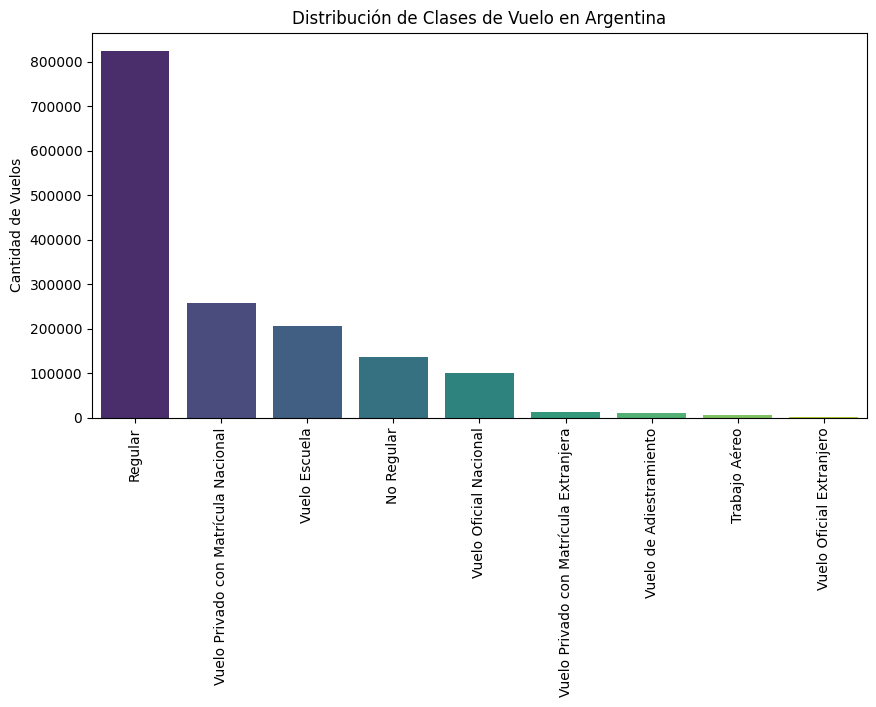

In [23]:
# Obtener la cuenta de cada clase de vuelo
clase_vuelo_counts = df_vuelos_combinado_correct_dtype['clase_de_vuelo'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(10, 5))
sns.barplot(x=clase_vuelo_counts.index, y=clase_vuelo_counts.values, hue=clase_vuelo_counts.index, legend=False, palette='viridis')
plt.title('Distribución de Clases de Vuelo en Argentina')
plt.xlabel('')
plt.ylabel('Cantidad de Vuelos')
plt.xticks(rotation=90)
plt.show()

Análisis de clasificaciónes de vuelo

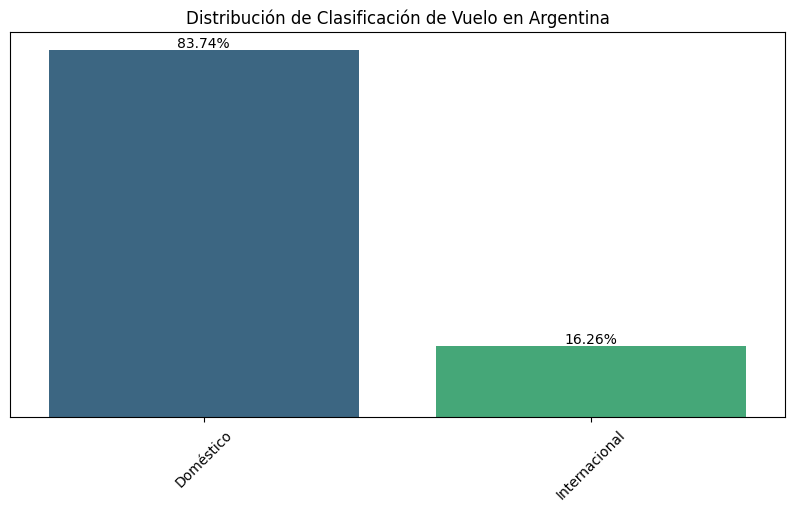

In [24]:
# Obtener la cuenta de cada clasificación de vuelo
clase_vuelo_counts = df_vuelos_combinado_correct_dtype['clasificación_vuelo'].value_counts()

# Calcular los porcentajes sobre el total
total_vuelos = len(df_vuelos_combinado_correct_dtype)
porcentajes = (clase_vuelo_counts / total_vuelos) * 100

# Crear una gráfica de barras
plt.figure(figsize=(10, 5))
barplot = sns.barplot(x=porcentajes.index, y=porcentajes.values, hue=porcentajes.index, legend=False, palette='viridis')

# Agregar etiquetas de porcentaje sobre las barras
for i in range(len(porcentajes)):
    plt.annotate(f'{porcentajes[i]:.2f}%',
                 xy=(i, porcentajes[i]),
                 ha='center',
                 va='bottom')

plt.title('Distribución de Clasificación de Vuelo en Argentina')
plt.xlabel('')
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)  # Ocultar eje y
plt.show()



---



**Conclusiones:**

* La mayoría de los vuelos son domésticos



---






Top 50 de columna origen/destino

In [25]:
# Obtener el top 50 de la columna 'origen_destino'
top_50_origen_destino = df_vuelos_combinado_correct_dtype['origen_destino'].value_counts().head(50)

# Mostrar los valores del top 5
top_50_origen_destino.reset_index()

,origen_destino,count
0,AER,246563
1,MOR,129497
2,FDO,96952
3,EZE,60158
4,CBA,56862
5,DOZ,54712
6,BAR,47673
7,NEU,41412
8,SCEL,33083
9,SAL,32418


**Conclusiones:**

Analizando el top 50 de vuelos origen/destino podemos ver que LEMD (Madrid) se encuentra en el puesto 39, sería conveniente utilizar este destino para realizar el pronóstico de viajes a España.

Nos quedamos solo con vuelos a españa (Todos los destinos para comparar)

In [26]:
# Filtrar el DataFrame para incluir solo vuelos entre Argentina y España
aeropuertos=['LEMD', 'LEBL', 'MAD']
df_vuelos_argentina_españa_todos_los_destinos = df_vuelos_combinado_correct_dtype[df_vuelos_combinado_correct_dtype['origen_destino'].isin(aeropuertos)]

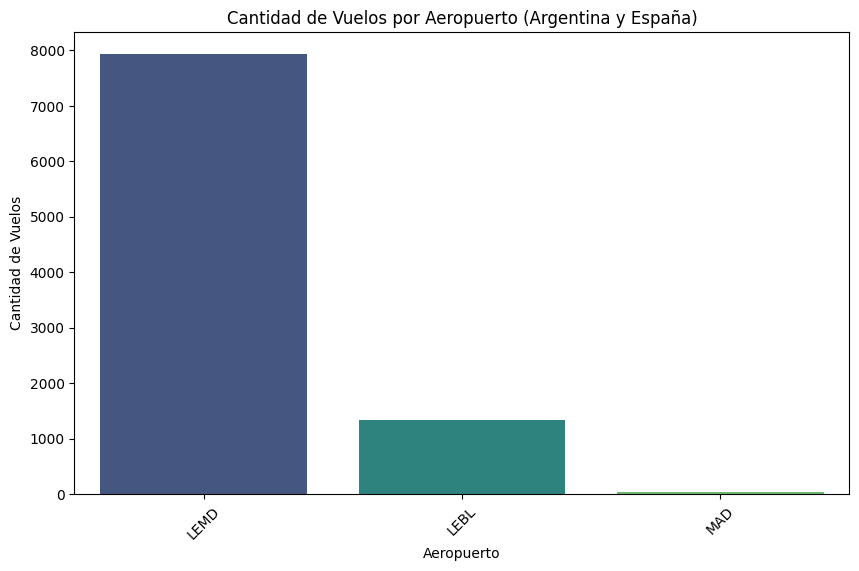

In [27]:
# Contar la cantidad de vuelos por aeropuerto
cantidad_vuelos_por_aeropuerto = df_vuelos_argentina_españa_todos_los_destinos['origen_destino'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=cantidad_vuelos_por_aeropuerto.index, y=cantidad_vuelos_por_aeropuerto.values, hue = cantidad_vuelos_por_aeropuerto.index, palette='viridis', legend=False)
plt.title('Cantidad de Vuelos por Aeropuerto (Argentina y España)')
plt.xlabel('Aeropuerto')
plt.ylabel('Cantidad de Vuelos')
for index, value in enumerate(cantidad_vuelos_por_aeropuerto):
    barplot.text(index, value, str(value), ha='center', va='bottom', fontsize=8)
plt.xticks(rotation=45)
plt.show()

In [28]:
# Observamos un caso que nos llamó la atención de un vuelo a España desde Bahía Blanca. Observamos que se trata de un Jet privado
análisis_puntual='BCA'
df_vuelos_puntual = df_vuelos_combinado_correct_dtype[df_vuelos_combinado_correct_dtype["aeropuerto"] == análisis_puntual]
df_vuelos_puntual = df_vuelos_puntual[df_vuelos_puntual['origen_destino'].isin(aeropuertos)]
df_vuelos_puntual

,fecha_utc,hora_utc,clase_de_vuelo,clasificación_vuelo,tipo_de_movimiento,aeropuerto,origen_destino,aerolinea_nombre,aeronave,pasajeros,pax,calidad_dato
18699,2021-01-25,18:07,Vuelo Privado con Matrícula Nacional,Doméstico,Despegue,BCA,MAD,0,CE-182-P,0,0,DEFINITIVO
42670,2021-02-24,16:50,Vuelo Privado con Matrícula Nacional,Doméstico,Aterrizaje,BCA,MAD,0,CE-182-P,0,0,DEFINITIVO
325757,2021-12-29,20:51,Vuelo Privado con Matrícula Nacional,Doméstico,Despegue,BCA,MAD,0,CE-182-P,0,0,DEFINITIVO
658925,2022-09-12,17:50,Vuelo Privado con Matrícula Nacional,Doméstico,Despegue,BCA,MAD,0,CE-182-P,0,0,DEFINITIVO


Filtramos solo vuelos a LEMD para nuestro análisis

In [29]:
# Filtramos el DataFrame para incluir solo vuelos entre Argentina y España ('LEMD')
aeropuerto_elegido ='LEMD'
df_vuelos_argentina_españa = df_vuelos_combinado_correct_dtype[df_vuelos_combinado_correct_dtype['origen_destino'].isin([aeropuerto_elegido])]

In [30]:
df_vuelos_argentina_españa.head(5)

,fecha_utc,hora_utc,clase_de_vuelo,clasificación_vuelo,tipo_de_movimiento,aeropuerto,origen_destino,aerolinea_nombre,aeronave,pasajeros,pax,calidad_dato
294,2021-01-02,00:45,Regular,Internacional,Despegue,EZE,LEMD,AIR EUROPA LINEAS AEREAS,0,235,235,DEFINITIVO
395,2021-01-02,11:13,Regular,Internacional,Aterrizaje,EZE,LEMD,AIR EUROPA LINEAS AEREAS,0,212,212,DEFINITIVO
403,2021-01-02,11:25,Regular,Internacional,Aterrizaje,EZE,LEMD,IBERIA - LINEAS AÉREAS DE ESPAÑA,0,189,189,DEFINITIVO
724,2021-01-02,17:19,Regular,Internacional,Despegue,EZE,LEMD,IBERIA - LINEAS AÉREAS DE ESPAÑA,0,221,221,DEFINITIVO
1056,2021-01-03,11:17,Regular,Internacional,Aterrizaje,EZE,LEMD,IBERIA - LINEAS AÉREAS DE ESPAÑA,0,160,160,DEFINITIVO


In [31]:
df_vuelos_argentina_españa.shape

(7932, 12)

Analizamos cantidad de pasajeros por mes

In [32]:
monthly_passengers = df_vuelos_argentina_españa.copy()
monthly_passengers.set_index('fecha_utc', inplace=True)
monthly_passengers = monthly_passengers['pasajeros'].resample('M').sum()
monthly_passengers.head(10)

fecha_utc
2021-01-31    17842
2021-02-28    11950
2021-03-31     8246
2021-04-30     9609
2021-05-31     9488
2021-06-30    18110
2021-07-31    14303
2021-08-31    19985
2021-09-30    20199
2021-10-31    26334
Freq: M, Name: pasajeros, dtype: int64

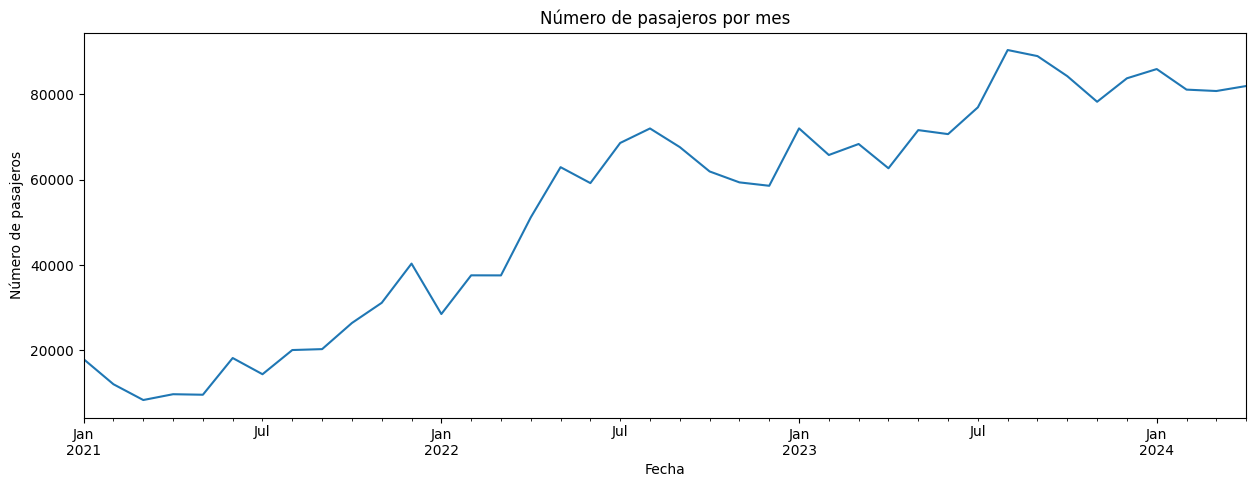

In [33]:
plt.figure(figsize=(15, 5))
monthly_passengers.plot()
plt.title('Número de pasajeros por mes')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.show()

Nuestro objetivo es extrapolar la demanda según fecha con los precios de vuelo para poder predecir cuando volar más barato. En ese caso, nos enfocaremos en un caso práctico que es vuelos que conecten Argentina y España. Por ese motivo, para el estudio nos quedaremos con:

*   Para el entrenamiento, vuelos entre 2021 y 2023. Para la prueba, vuelos de 2024
*   Vuelos que involucren el aeropuerto español LEMD
*   Vuelos comerciales
*   Contemplamos tanto despegues como aterrizajes, es decir, IDA y VUELTA
* Eliminamos filas con fecha o cantidad de pasajeros nulos

In [34]:
aeropuerto_españa = ['LEMD']
clase_vuelo = 'Regular'

# Filtrar el DataFrame original
df_argentina_españa_comerciales = df_vuelos_combinado_correct_dtype[
    (df_vuelos_combinado_correct_dtype['origen_destino'].isin(aeropuerto_españa)) &
    (df_vuelos_combinado_correct_dtype['clase_de_vuelo'] == clase_vuelo)
]

num_vuelos = df_argentina_españa_comerciales.shape[0]
print(f"El número de vuelos en el dataset filtrado es de: {num_vuelos}")

El número de vuelos en el dataset filtrado es de: 7831


In [35]:
# Crear el dataset_train con registros entre 2021 y 2023
lim_inferior_entrenamiento=2021
lim_superior_entrenamiento=2023
lim_inferior_prueba=2024
lim_superior_prueba=2024

dataset_train = df_argentina_españa_comerciales[
    (df_argentina_españa_comerciales['fecha_utc'].dt.year >= lim_inferior_entrenamiento) &
    (df_argentina_españa_comerciales['fecha_utc'].dt.year <= lim_superior_entrenamiento)
]

# Crear el dataset_test con registros del año 2024
dataset_test = df_argentina_españa_comerciales[
    (df_argentina_españa_comerciales['fecha_utc'].dt.year >= lim_inferior_prueba) &
    (df_argentina_españa_comerciales['fecha_utc'].dt.year <= lim_superior_prueba)
]

# Imprimir el número de registros en cada dataset
print(f"El número de registros en dataset_train es: {len(dataset_train)}")
print(f"El número de registros en dataset_test es: {len(dataset_test)}")

El número de registros en dataset_train es: 6695
El número de registros en dataset_test es: 1136


Evaluamos gráficamente la cantidad de pasajeros por mes del DATASET de entrenamiento que contará con todos los mesese de los años 2021 a 2023, arrojandonos un resultado más concreto de como se desarrolla la variación en función del tiempo

In [36]:
monthly_passengers_filtering = dataset_train.copy()
monthly_passengers_filtering.set_index('fecha_utc', inplace=True)
monthly_passengers_filtering = monthly_passengers_filtering['pasajeros'].resample('M').sum()
monthly_passengers_filtering.reset_index()
monthly_passengers_filtering.head(10)

fecha_utc
2021-01-31    17519
2021-02-28    11930
2021-03-31     8244
2021-04-30     9609
2021-05-31     9488
2021-06-30    18109
2021-07-31    14299
2021-08-31    19985
2021-09-30    20194
2021-10-31    26331
Freq: M, Name: pasajeros, dtype: int64

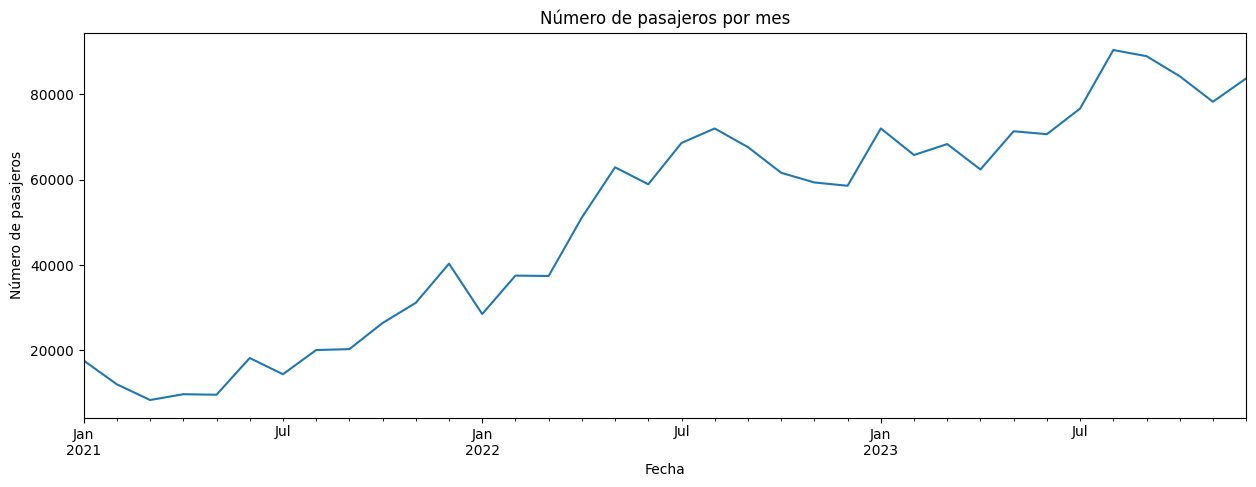

In [37]:
plt.figure(figsize=(15, 5))
monthly_passengers_filtering.plot()
plt.title('Número de pasajeros por mes')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.show()

Identificamos los aeropuertos argentinos, las aerolíneas y las aeronaves que guardan vínculo con estos viajes a España para vuelos comerciales en dicha fecha:

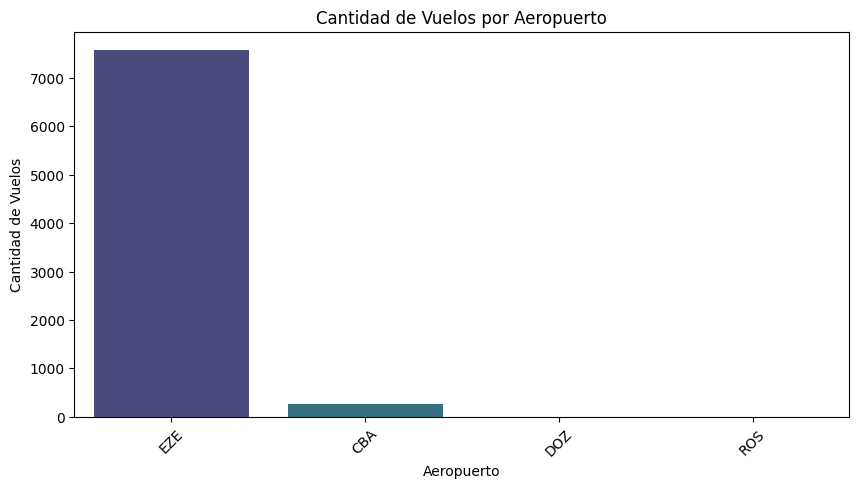

In [38]:
# Gráfico de barra para la columna 'aeropuerto'
cantidad_vuelos_por_aeropuerto = df_argentina_españa_comerciales['aeropuerto'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=cantidad_vuelos_por_aeropuerto.index, y=cantidad_vuelos_por_aeropuerto.values, hue=cantidad_vuelos_por_aeropuerto.index, legend=False, palette='viridis')
plt.title('Cantidad de Vuelos por Aeropuerto')
plt.xlabel('Aeropuerto')
plt.ylabel('Cantidad de Vuelos')
plt.xticks(rotation=45)
plt.show()

In [39]:
# Obtener el top 3 de la columna 'origen_destino'
top_3_aerolineas = df_argentina_españa_comerciales['aerolinea_nombre'].value_counts().head(3)

# Mostrar los valores del top 3
top_3_aerolineas.reset_index()

,aerolinea_nombre,count
0,IBERIA - LINEAS AÉREAS DE ESPAÑA,3557
1,AEROLINEAS ARGENTINAS SA,2245
2,AIR EUROPA LINEAS AEREAS,2012


In [40]:
# Reseteamos el índice y lo convertimos a lista
lista_top_3 = top_3_aerolineas.reset_index().values.tolist()

# Extraemos solo los nombres de las aerolíneas
lista_top_3_names = top_3_aerolineas.index.tolist()

In [41]:
lista_top_3_names

['IBERIA - LINEAS AÉREAS DE ESPAÑA',
 'AEROLINEAS ARGENTINAS SA',
 'AIR EUROPA LINEAS AEREAS']

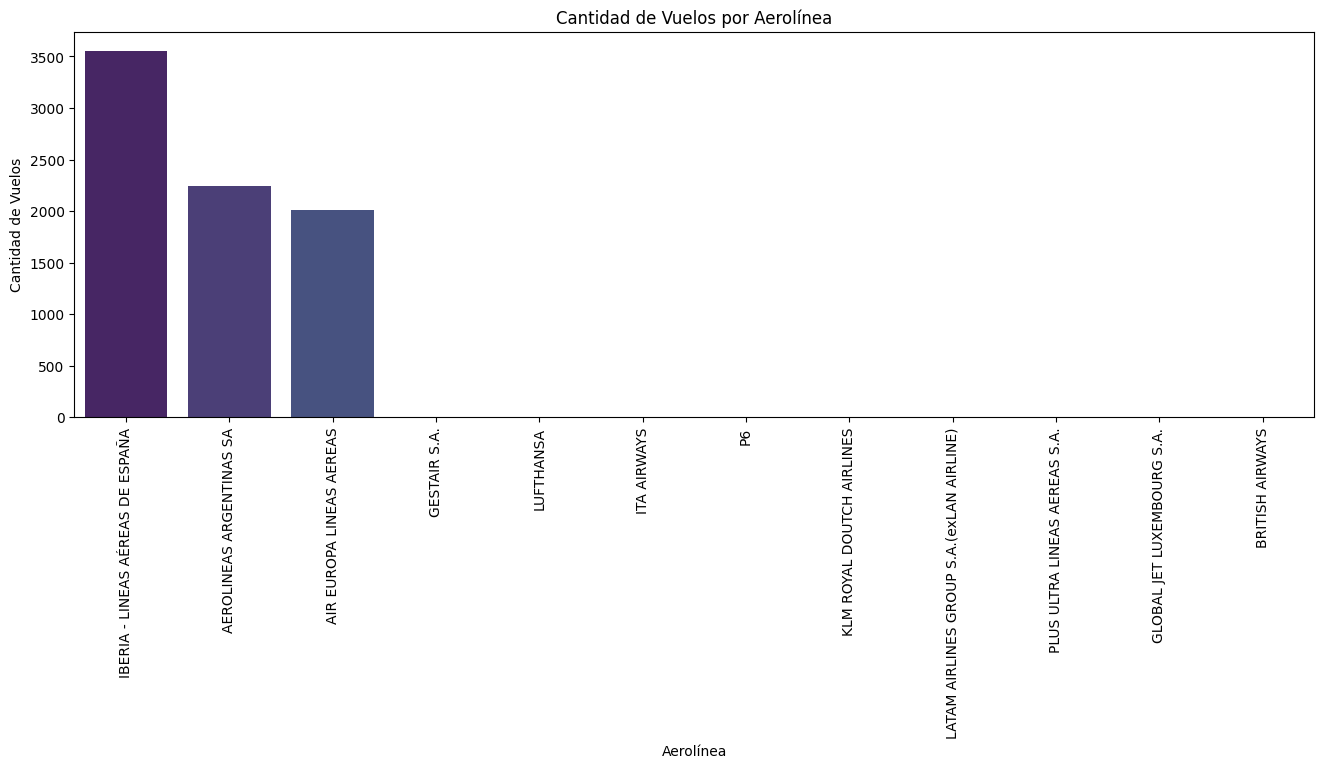

In [42]:
# Gráfico de barra para la columna 'aerolinea_nombre'
cantidad_vuelos_por_aerolinea = df_argentina_españa_comerciales['aerolinea_nombre'].value_counts()

plt.figure(figsize=(16, 5))
sns.barplot(x=cantidad_vuelos_por_aerolinea.index, y=cantidad_vuelos_por_aerolinea.values,hue=cantidad_vuelos_por_aerolinea.index, legend=False,palette='viridis')
plt.title('Cantidad de Vuelos por Aerolínea')
plt.xlabel('Aerolínea')
plt.ylabel('Cantidad de Vuelos')
plt.xticks(rotation=90)
plt.show()

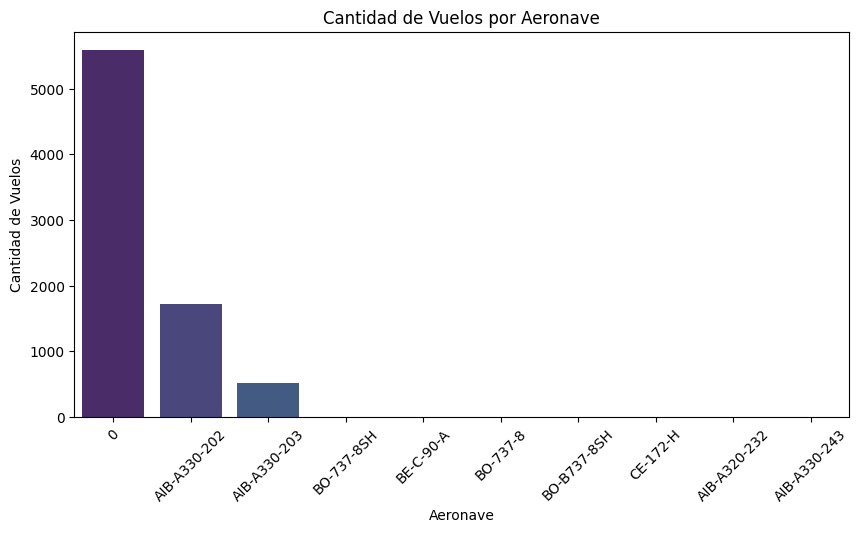

In [43]:
# Gráfico de barra para la columna 'aeronave'
cantidad_vuelos_por_aeronave = df_argentina_españa_comerciales['aeronave'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=cantidad_vuelos_por_aeronave.index, y=cantidad_vuelos_por_aeronave.values,hue=cantidad_vuelos_por_aeronave.index,legend=False, palette='viridis')
plt.title('Cantidad de Vuelos por Aeronave')
plt.xlabel('Aeronave')
plt.ylabel('Cantidad de Vuelos')
plt.xticks(rotation=45)
plt.show()

Elegimos el par EZE - LEMD

In [44]:
aeropuerto_españa = ['LEMD']
clase_vuelo = 'Regular'
aeropuerto_base = 'EZE'

# Filtrar el DataFrame original
df_vuelos_pre_final = df_vuelos_combinado_correct_dtype[
    (df_vuelos_combinado_correct_dtype['origen_destino'].isin(aeropuerto_españa)) &
    (df_vuelos_combinado_correct_dtype['clase_de_vuelo'] == clase_vuelo) &
    (df_vuelos_combinado_correct_dtype['aeropuerto'] == aeropuerto_base)
]

num_vuelos = df_vuelos_pre_final.shape[0]
print(f"El número de vuelos en el dataset filtrado es de: {num_vuelos}")

El número de vuelos en el dataset filtrado es de: 7572


In [45]:
df_vuelos_pre_final.head()

,fecha_utc,hora_utc,clase_de_vuelo,clasificación_vuelo,tipo_de_movimiento,aeropuerto,origen_destino,aerolinea_nombre,aeronave,pasajeros,pax,calidad_dato
294,2021-01-02,00:45,Regular,Internacional,Despegue,EZE,LEMD,AIR EUROPA LINEAS AEREAS,0,235,235,DEFINITIVO
395,2021-01-02,11:13,Regular,Internacional,Aterrizaje,EZE,LEMD,AIR EUROPA LINEAS AEREAS,0,212,212,DEFINITIVO
403,2021-01-02,11:25,Regular,Internacional,Aterrizaje,EZE,LEMD,IBERIA - LINEAS AÉREAS DE ESPAÑA,0,189,189,DEFINITIVO
724,2021-01-02,17:19,Regular,Internacional,Despegue,EZE,LEMD,IBERIA - LINEAS AÉREAS DE ESPAÑA,0,221,221,DEFINITIVO
1056,2021-01-03,11:17,Regular,Internacional,Aterrizaje,EZE,LEMD,IBERIA - LINEAS AÉREAS DE ESPAÑA,0,160,160,DEFINITIVO


<Axes: xlabel='fecha_utc'>

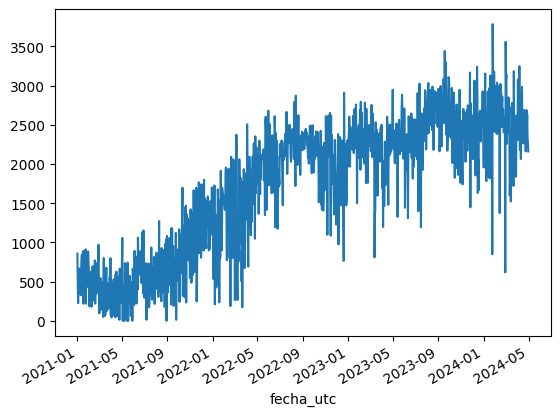

In [46]:
# Evolución de pasajeros en el tiempo

df_vuelos_pre_final.groupby('fecha_utc')['pasajeros'].sum().plot()

In [47]:
df_final = df_vuelos_pre_final[['fecha_utc', 'pasajeros']].copy()
df_final.head()

,fecha_utc,pasajeros
294,2021-01-02,235
395,2021-01-02,212
403,2021-01-02,189
724,2021-01-02,221
1056,2021-01-03,160


In [48]:
df_final.dtypes

fecha_utc    datetime64[ns]
pasajeros             int64
dtype: object

#### 1.2.1) Analizamos la Serie Temporal

In [49]:
# Transformamos la data a frecuencia semanal, agrupamos
df_monthly = df_final.resample('M', on='fecha_utc').sum()

# Generamos un rango mensual para el índice
monthly_index = pd.date_range(start='2021-01-01', end='2024-04-01', freq='MS')

# Nos aseguramos de que la longitud del nuevo índice matchee con la de nuestro Dataframe
if len(monthly_index) == len(df_monthly):
    df_monthly.index = monthly_index
else:
    raise ValueError(f"Length mismatch: The new index has {len(monthly_index)} elements, but the DataFrame has {len(df_monthly)} rows.")

print(df_monthly)

            pasajeros
2021-01-01      17519
2021-02-01      11930
2021-03-01       8244
2021-04-01       9609
2021-05-01       9488
2021-06-01      18109
2021-07-01      14299
2021-08-01      19727
2021-09-01      20194
2021-10-01      26331
2021-11-01      31069
2021-12-01      40266
2022-01-01      28441
2022-02-01      37461
2022-03-01      37370
2022-04-01      51112
2022-05-01      62899
2022-06-01      58640
2022-07-01      68615
2022-08-01      72013
2022-09-01      67638
2022-10-01      61609
2022-11-01      59336
2022-12-01      58559
2023-01-01      72026
2023-02-01      65782
2023-03-01      68353
2023-04-01      62388
2023-05-01      71363
2023-06-01      67530
2023-07-01      72814
2023-08-01      83518
2023-09-01      81910
2023-10-01      77390
2023-11-01      72192
2023-12-01      76996
2024-01-01      79209
2024-02-01      74654
2024-03-01      73905
2024-04-01      75333


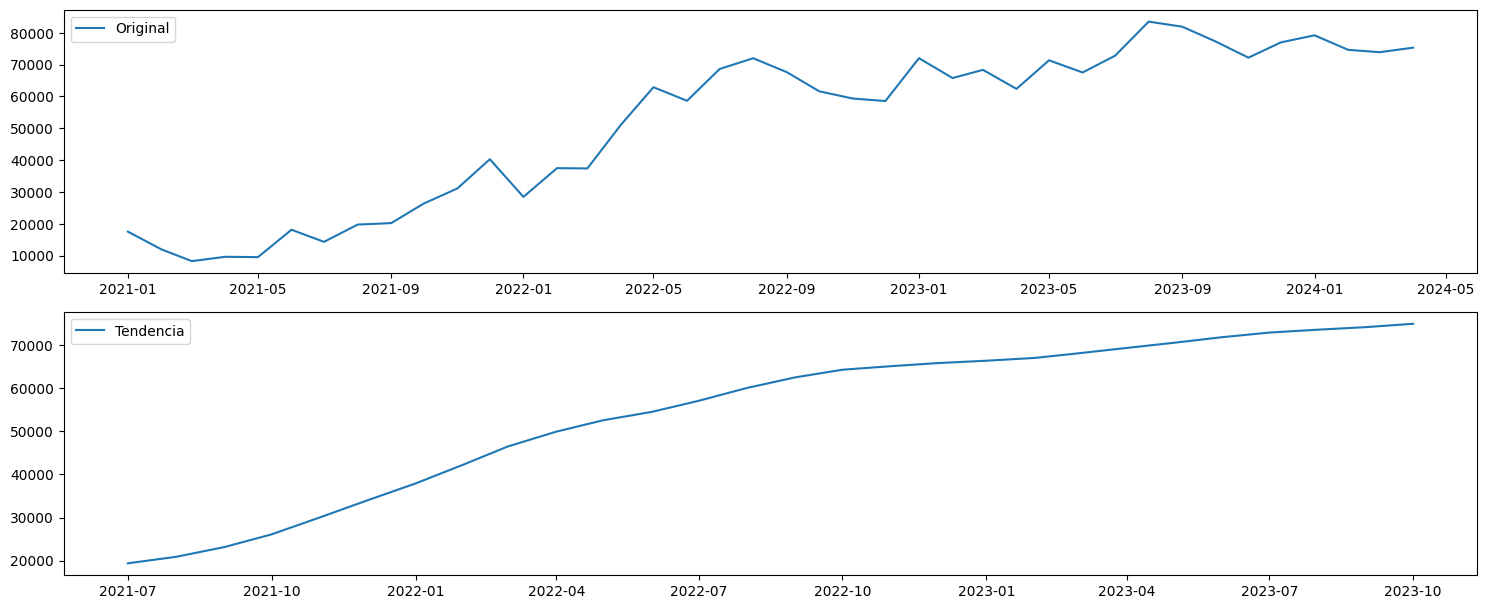

In [50]:
# Descomponemos la serie temporal
decomposition = seasonal_decompose(df_monthly['pasajeros'], model='multiplicative')

# Graficamos
plt.figure(figsize=(15, 12))

plt.subplot(411)
plt.plot(df_monthly['pasajeros'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


**Interpretación**

* **Original**

 La gráfica muestra una tendencia general al alza, con fluctuaciones evidentes que podrían indicar un patrón estacional.

* **Tendencia**

 La línea de tendencia muestra un aumento constante en el número de pasajeros a lo largo del tiempo. Esto sugiere que la demanda general de vuelos está creciendo.

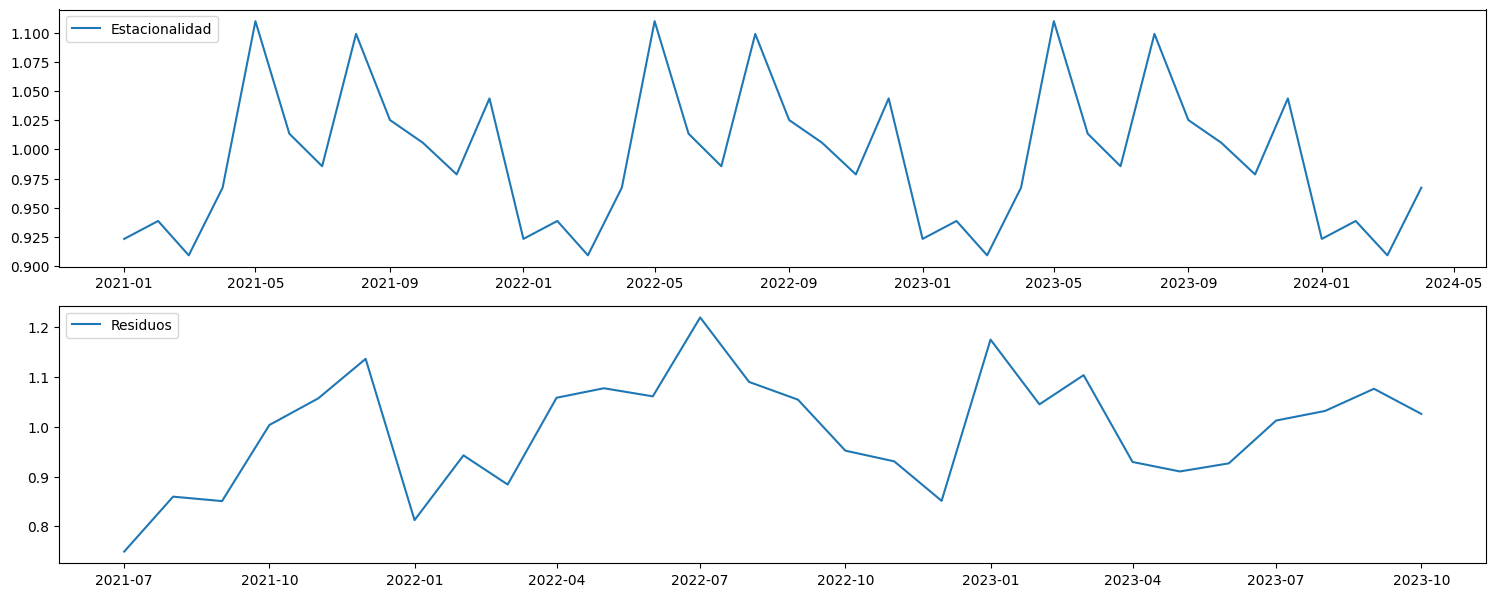

In [51]:
# Plot the decomposed components
plt.figure(figsize=(15, 12))

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuos')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

**Interpretación**

* **Estacionalidad**

 La gráfica estacional muestra picos y valles periódicos dentro de cada año. Esto sugiere un patrón estacional donde el número de pasajeros aumenta y disminuye regularmente en ciertas épocas del año. Por ejemplo, los picos podrían corresponder a temporadas de vacaciones u otros períodos de alta demanda, mientras que los valles podrían coincidir con períodos de baja demanda.

* **Residuos**

 La gráfica de residuos muestra las fluctuaciones restantes que no siguen un patrón de tendencia o estacionalidad. Estas podrían deberse a factores aleatorios, eventos especiales o anomalías. Idealmente, los residuos no deberían mostrar ningún patrón, lo que indicaría que el modelo ha capturado bien las partes sistemáticas de los datos.

In [52]:
# Establecemos 'fecha_utc' como índice
df_analysis = df_final.copy()
df_analysis.set_index('fecha_utc', inplace=True)

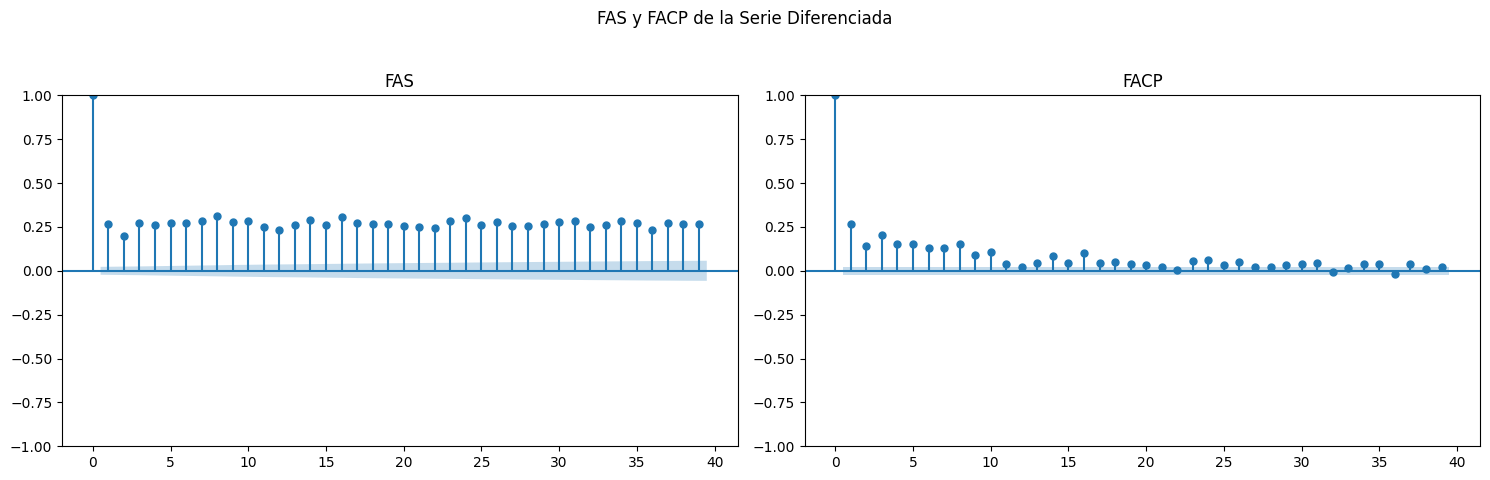

In [53]:
plot_acf_pacf(df_analysis)

**Interpretación**

En los gráficos ACF y PACF de la serie temporal diferenciada:

- **ACF:** Observamos una disminución gradual de la autocorrelación a medida que aumentan los retardos, indicando que la serie tiene una dependencia temporal significativa, incluso después de la diferenciación.
- **PACF:** Los primeros retardos muestran valores significativos, pero después de unos pocos retardos, la correlación cae cerca de cero, sugiriendo que la influencia directa de los retardos se limita a los primeros lags.


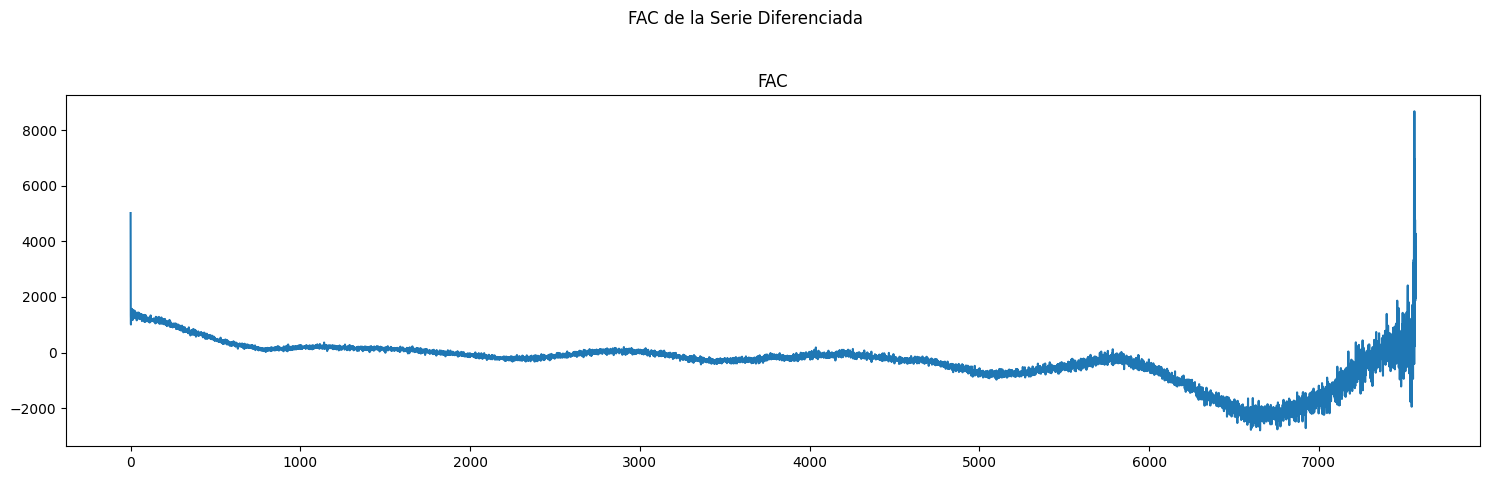

In [54]:
plot_fac(df_analysis)

**Análisis de FAC de la Serie Temporal Diferenciada**

**Propósito del Análisis:**

Buscamos entender la autocorrelación presente en la serie temporal después de la diferenciación para determinar si la serie es estacionaria e identificar patrones de dependencia temporal.

**Interpretación del Gráfico FAC**
- **Primera Observación Alta:** Indica una fuerte autocorrelación en el primer retardo, común en series diferenciadas.
- **Disminución Gradual:** La autocorrelación disminuye gradualmente, indicando una estructura de dependencia a lo largo del tiempo.
- **Valores Extremos:** Los picos en los extremos pueden indicar estacionalidad o cambios abruptos en la serie.


#### 1.2.2) Pruebas estadísticas

El objetivo principal es determinar si una serie temporal es estacionaria. Para lograrlo, vamos a utilizar tres pruebas estadísticas diferentes. La prueba de Zivot-Andrews se centrará en identificar una tendencia significativa en la media de la serie, mientras que la prueba de Dickey-Fuller Aumentada (ADF) nos ayudará a examinar la estacionariedad en la media. Por otro lado, la prueba de KPSS se enfocará en la estacionariedad en la varianza de la serie. Al realizar estas pruebas, buscamos comprender la naturaleza de la serie y determinar si son necesarias transformaciones o modelos específicos antes de proceder con su análisis y predicción.

In [55]:
stationarity_tests(df_analysis)

Stationarity Tests for: 
ADF Test:
ADF Test Statistic        -3.676001
p-value                    0.004464
# Lags Used               36.000000
# Observations          7535.000000
Critical Value (1%)       -3.431218
Critical Value (5%)       -2.861924
Critical Value (10%)      -2.566974


KPSS Test:
KPSS Test Statistic       5.703256
p-value                   0.010000
# Lags Used              49.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000




<ipython-input-3-6b88ebefe723>:109: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(df, regression='c', nlags='auto')


**Conclusiones**

Los resultados de la prueba ADF sugieren que la serie es estacionaria, ya que su valor p es menor que 0.05 y su estadística de prueba es menor que los valores críticos. Por otro lado, la prueba KPSS también indica estacionariedad, ya que su valor p es menor que 0.05 y su estadística de prueba excede los valores críticos. En conclusión, ambas pruebas respaldan la estacionariedad de la serie temporal.

Stationarity Tests:


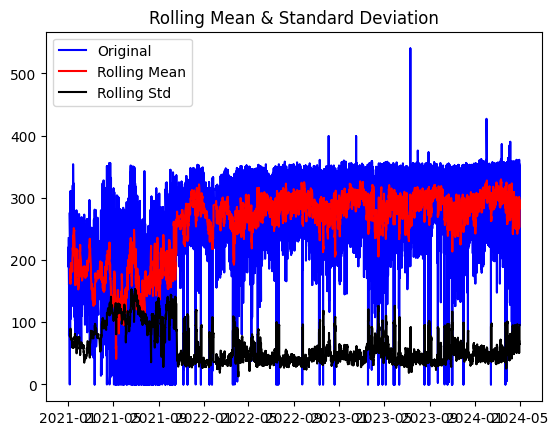

Results of Dickey-Fuller Test:
Test Statistic                   -3.676001
p-value                           0.004464
#Lags Used                       36.000000
Number of Observations Used    7535.000000
Critical Value (1%)              -3.431218
Critical Value (5%)              -2.861924
Critical Value (10%)             -2.566974
dtype: float64


In [56]:
test_stationarity(df_analysis)

**Conclusiones:**

Comprobamos mediante el test de Dickey-Fuller que nuestra serie es estacionaria. El valor de Test Statistic es menor que todos los valores críticos.

## 2. Análisis de importancia de Features

###2.1 Estudio PCA

In [57]:
df_argentina_españa_comerciales.dtypes

fecha_utc              datetime64[ns]
hora_utc               string[python]
clase_de_vuelo         string[python]
clasificación_vuelo    string[python]
tipo_de_movimiento     string[python]
aeropuerto             string[python]
origen_destino         string[python]
aerolinea_nombre       string[python]
aeronave               string[python]
pasajeros                       int64
pax                    string[python]
calidad_dato           string[python]
dtype: object

In [58]:
df_argentina_españa_comerciales['pax'] = df_argentina_españa_comerciales.pax.astype('int64')

<ipython-input-58-874d6d985512>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_argentina_españa_comerciales['pax'] = df_argentina_españa_comerciales.pax.astype('int64')


In [59]:
# Hago dummies para aquellas features las cuales pueden categorizarse
dummies_columns = ['tipo_de_movimiento', 'aerolinea_nombre', 'aeronave']

# TODO - cambiar por oneHotEncoder
df_argentina_españa_comerciales_dummies = pd.get_dummies(df_argentina_españa_comerciales, columns= dummies_columns)

In [60]:
df_argentina_españa_comerciales_dummies.dtypes

fecha_utc                                                    datetime64[ns]
hora_utc                                                     string[python]
clase_de_vuelo                                               string[python]
clasificación_vuelo                                          string[python]
aeropuerto                                                   string[python]
origen_destino                                               string[python]
pasajeros                                                             int64
pax                                                                   int64
calidad_dato                                                 string[python]
tipo_de_movimiento_Aterrizaje                                          bool
tipo_de_movimiento_Despegue                                            bool
aerolinea_nombre_AEROLINEAS ARGENTINAS SA                              bool
aerolinea_nombre_AIR EUROPA LINEAS AEREAS                              bool
aerolinea_no

In [61]:
# Separar las variables numéricas
type_numeric_list = ['bool', 'datetime64']
drop_train_cols_list = ['pasajeros', 'pax']

df_train = df_argentina_españa_comerciales_dummies.select_dtypes(include= type_numeric_list)

# separo los datos de train, que abarcan los años 2021 hasta 2023, y test a usar el 2024
df_train = date_filter(df_train, 'fecha_utc', lim_inferior_entrenamiento, lim_superior_entrenamiento)
df_test = date_filter(df_train, 'fecha_utc', lim_inferior_prueba, lim_superior_prueba)

df_train_pca = df_train.copy()
df_train_pca['fecha_int64'] = df_train_pca.fecha_utc.apply(lambda x: x.strftime('%Y%m%d')).astype('int64')
df_train_pca.drop(columns= ['fecha_utc'], inplace= True)

# Escalar las variables numéricas
scaler = StandardScaler()
X_numerico_scaled = scaler.fit_transform(df_train_pca)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit(X_numerico_scaled)

# Calcular la varianza explicada por cada componente principal
explained_variance_ratio = pca.explained_variance_ratio_

# Imprimir la varianza explicada acumulada
print("Varianza explicada acumulada por componente principal:")
print(explained_variance_ratio.cumsum())

Varianza explicada acumulada por componente principal:
[0.13463421 0.21487452 0.27559135 0.32333097 0.36411349 0.40419738
 0.44423096 0.48424996 0.52426031 0.56427009 0.60427859 0.64428457
 0.68429054 0.72429652 0.76430249 0.80430847 0.84431444 0.88432042
 0.92432588 0.96413822 0.99998802 1.         1.         1.
 1.        ]


Varianza explicada acumulada por componente principal:
[0.13463421 0.21487452 0.27559135 0.32333097 0.36411349 0.40419738
 0.44423096 0.48424996 0.52426031 0.56427009 0.60427859 0.64428457
 0.68429054 0.72429652 0.76430249 0.80430847 0.84431444 0.88432042
 0.92432588 0.96413822 0.99998802 1.         1.         1.
 1.        ]
Se requieren las primeras 21 componentes principales para explicar el 99.99% de la varianza.

Características comunes en las 21 componentes principales:
{'tipo_de_movimiento_Despegue', 'aeronave_AIB-A330-243', 'aerolinea_nombre_LATAM AIRLINES GROUP S.A.(exLAN AIRLINE)', 'aerolinea_nombre_LUFTHANSA', 'aeronave_AIB-A330-202', 'aerolinea_nombre_IBERIA - LINEAS AÉREAS DE ESPAÑA', 'aerolinea_nombre_PLUS ULTRA LINEAS AEREAS S.A.', 'aeronave_BO-B737-8SH', 'aerolinea_nombre_GESTAIR S.A.', 'aerolinea_nombre_AIR EUROPA LINEAS AEREAS', 'aerolinea_nombre_KLM ROYAL DOUTCH AIRLINES', 'aerolinea_nombre_P6', 'aerolinea_nombre_ITA AIRWAYS', 'aeronave_CE-172-H', 'aeronave_BO-737-8'

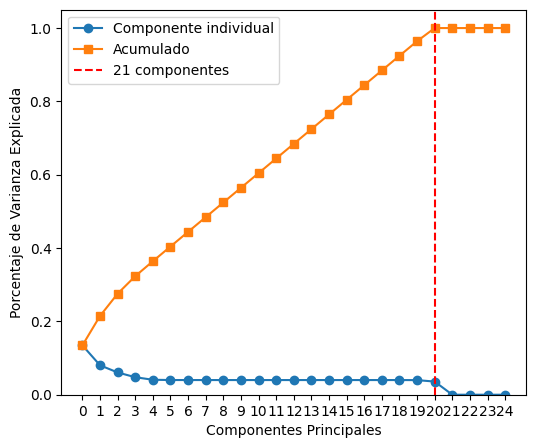

In [62]:
# Imprimir la varianza explicada acumulada
cumulative_variance = explained_variance_ratio.cumsum()
print("Varianza explicada acumulada por componente principal:")
print(cumulative_variance)

# Determinar el número de componentes necesarios para explicar el 99.99% de la varianza
num_components = np.argmax(cumulative_variance >= 0.9999) + 1
print(f"Se requieren las primeras {num_components} componentes principales para explicar el 99.99% de la varianza.")

# Transformar los datos usando solo las componentes necesarias
pca = PCA(n_components=num_components)
X_pca_reduced = pca.fit_transform(X_numerico_scaled)

# Obtener las cargas de los componentes
component_loadings = pca.components_

# Crear un DataFrame para las cargas
loadings_df = pd.DataFrame(component_loadings.T, columns=[f'PC{i+1}' for i in range(num_components)], index=df_train_pca.columns)

# Identificar las características más importantes para cada componente
important_features = {}
for i in range(num_components):
    component = f'PC{i+1}'
    sorted_loadings = loadings_df[component].abs().sort_values(ascending=False)
    important_features[component] = sorted_loadings.index.tolist()

# Encontrar características comunes en las 21 componentes principales
common_features = set(important_features['PC1'])
for i in range(2, num_components + 1):
    common_features.intersection_update(important_features[f'PC{i}'])

print("\nCaracterísticas comunes en las 21 componentes principales:")
print(common_features)

# Graficar la varianza explicada
plt.figure(figsize=(6, 5))
plt.plot(range(len(explained_variance_ratio)), explained_variance_ratio, '-o', label='Componente individual')
plt.plot(range(len(explained_variance_ratio)), cumulative_variance, '-s', label='Acumulado')
plt.axvline(x=num_components-1, color='r', linestyle='--', label=f'{num_components} componentes')
plt.ylabel('Porcentaje de Varianza Explicada')
plt.xlabel('Componentes Principales')
plt.ylim(0, 1.05)
plt.xticks(range(len(explained_variance_ratio)))
plt.legend(loc='best')
plt.show()

No es posible hacer una limpieza más exhaustiva que la realizada en el EDA con el método PCA.

## 3. Definimos Dataset final para Entrenamiento

In [63]:
df_final_entrenamiento = df_vuelos_pre_final[['fecha_utc', 'pasajeros']].copy()

# Transformamos la data a frecuencia semanal, agrupamos
df_final_mensual_entrenamiento = df_final_entrenamiento.resample('M', on='fecha_utc').sum()

# Generamos un rango mensual para el índice
monthly_index = pd.date_range(start='2021-01-01', end='2024-04-01', freq='MS')

# Nos aseguramos de que la longitud del nuevo índice matchee con la de nuestro Dataframe
if len(monthly_index) == len(df_final_mensual_entrenamiento):
    df_final_mensual_entrenamiento.index = monthly_index
else:
    raise ValueError(f"Length mismatch: The new index has {len(monthly_index)} elements, but the DataFrame has {len(df_final_mensual_entrenamiento)} rows.")

df_final_mensual_entrenamiento.head()

,pasajeros
2021-01-01,17519
2021-02-01,11930
2021-03-01,8244
2021-04-01,9609
2021-05-01,9488


## 4. Entrenamiento

## 4.1) Entrenamos con ExponentialSmoothing

#### 4.1.1) Sin estacionalidad

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


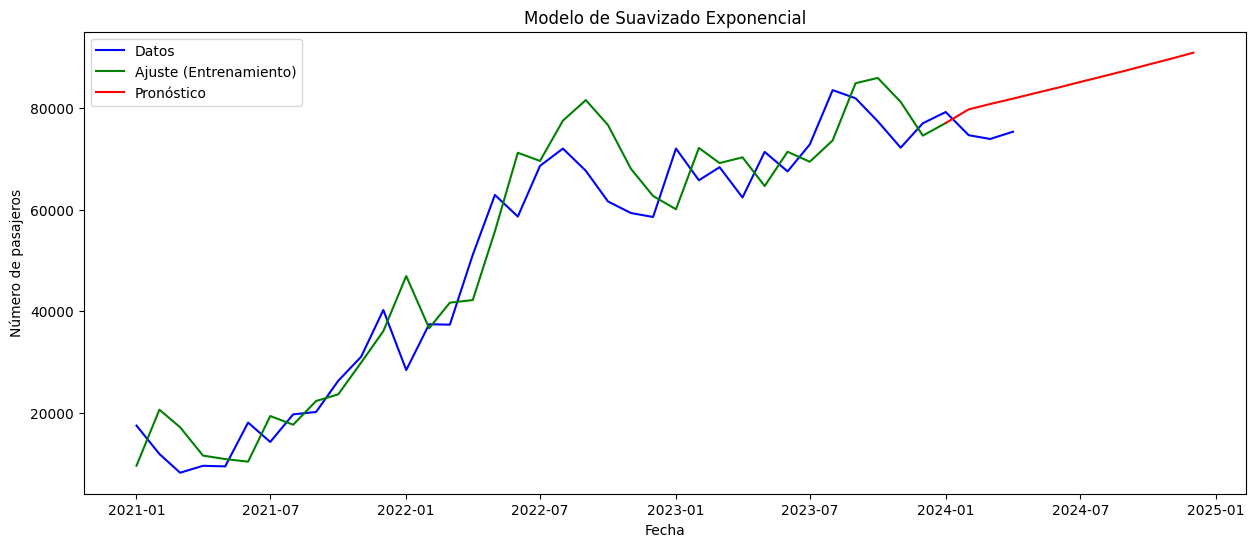

In [64]:
# Obtenemos los primeros 3 años de datos
train_start_date_se = df_final_mensual_entrenamiento.index[0]  # Fecha del primer dato
train_end_date_se  = train_start_date_se + pd.DateOffset(years=3)  # Fecha después de 3 años

train_se = df_final_mensual_entrenamiento.loc[train_start_date_se:train_end_date_se]

# Entenamiento del modelo
exp_model_se = ExponentialSmoothing(train_se, trend='mul')
exp_model_fit_se = exp_model_se.fit()

# Pronóstico
forecast_steps_se = 12 # Por ejemplo, pronosticar un año después del entrenamiento
forecast_start_date_se = train_end_date_se + pd.DateOffset(months=0)  # Fecha de inicio para pronosticar
forecast_end_date_se = forecast_start_date_se + pd.DateOffset(months=forecast_steps_se - 1)  # Fecha de finalización para pronosticar
forecast_se = exp_model_fit_se.predict(start=forecast_start_date_se, end=forecast_end_date_se)

# Graficamos
plt.figure(figsize=(15, 6))
plt.plot(df_final_mensual_entrenamiento.index, df_final_mensual_entrenamiento.pasajeros, label='Datos', color='blue')
plt.plot(train_se.index, exp_model_fit_se.fittedvalues, label='Ajuste (Entrenamiento)', color='green')
plt.plot(forecast_se.index, forecast_se, label='Pronóstico', color='red')
plt.title('Modelo de Suavizado Exponencial')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.legend()
plt.show()

In [65]:
train_forecast_se = exp_model_fit_se.predict(start=0, end=36)
test_forecast_se = exp_model_fit_se.predict(start=36, end=40)

test_se = df_final_mensual_entrenamiento[-5:]

##### Analizamos métricas de performance

In [66]:
print('RMSE train: ', np.sqrt(mean_squared_error(train_se, train_forecast_se)))
print('RMSE test: ', np.sqrt(mean_squared_error(test_se, test_forecast_se)))
print('MAE train: ', mean_absolute_error(train_se, train_forecast_se))
print('MAE test: ', mean_absolute_error(test_se, test_forecast_se))

RMSE train:  7580.629329952349
RMSE test:  5625.846201947403
MAE train:  6227.580553979768
MAE test:  4441.844638102132


##### Analizamos residuos

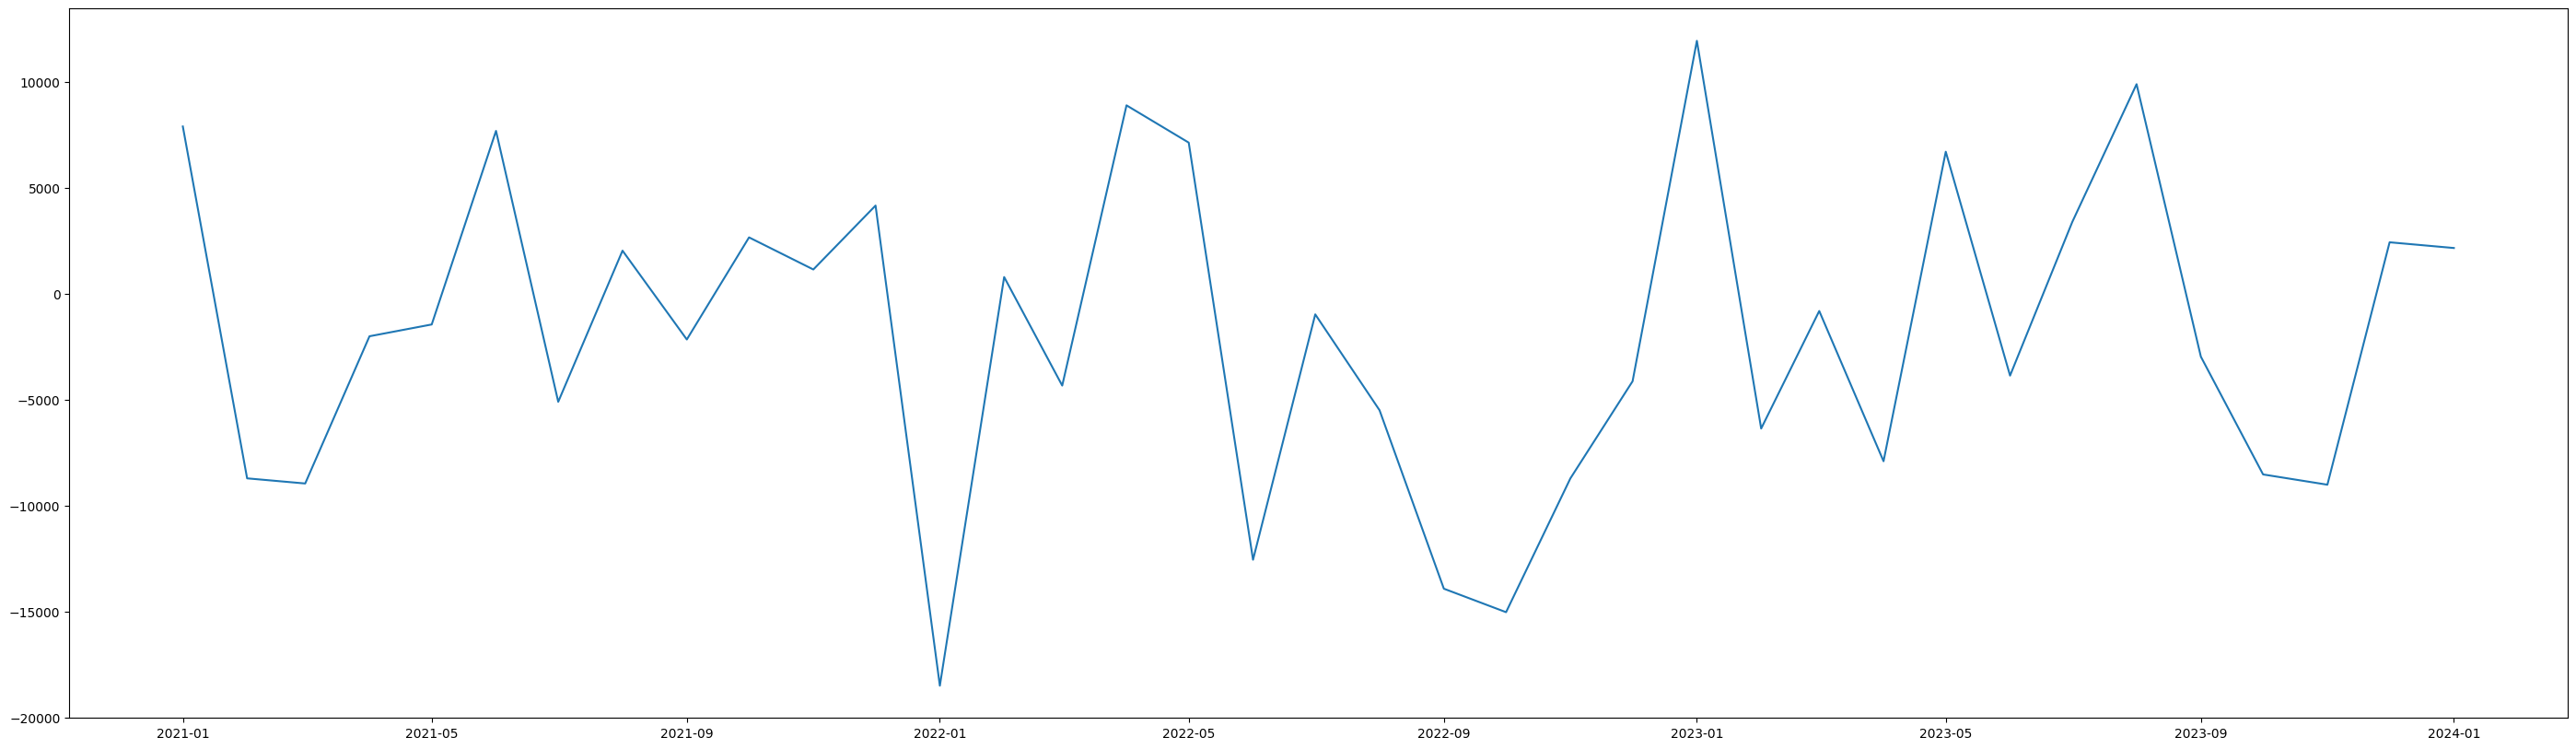

In [67]:
plt.figure(figsize=(35,10))
plt.plot(exp_model_fit_se.resid)

Observaciones

Se observa un comportamiento aleatorio en los residuos, lo que implica que no hay patrones presentes. Esto sugiere que el modelo entrenado ha capturado adecuadamente las tendencias y estacionalidades relevantes de los datos.

### 4.1.2) Con estacionalidad

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


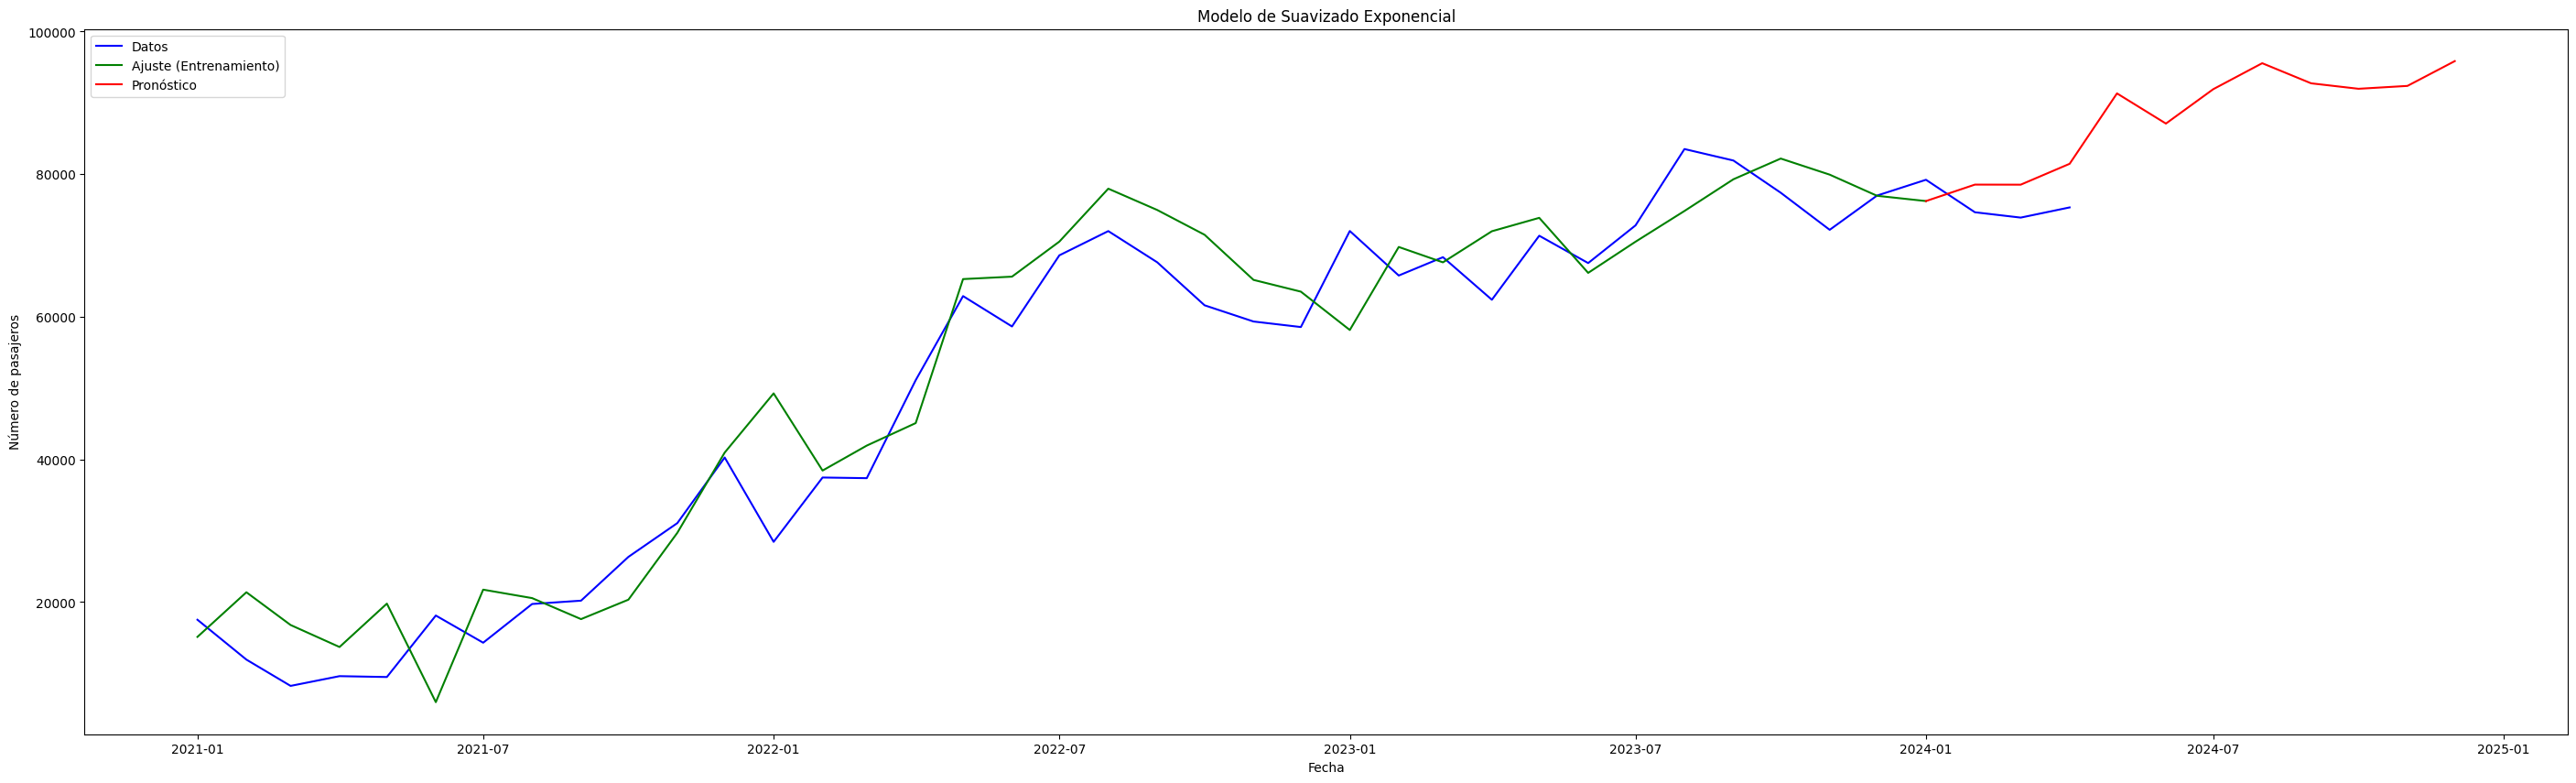

In [68]:
# Obtenemos los primeros 3 años de datos
train_start_date_ce = df_final_mensual_entrenamiento.index[0]  # Fecha del primer dato
train_end_date_ce = train_start_date_ce + pd.DateOffset(years=3)  # Fecha después de 3 años

train_ce = df_final_mensual_entrenamiento.loc[train_start_date_ce:train_end_date_ce]

# Entenamiento del modelo
exp_model_ce = ExponentialSmoothing(train_ce, seasonal='add', trend='mul', seasonal_periods=12)
exp_model_fit_ce = exp_model_ce.fit()

# Pronóstico
forecast_steps_ce = 12 # Por ejemplo, pronosticar un año después del entrenamiento
forecast_start_date_ce = train_end_date_ce + pd.DateOffset(months=0)  # Fecha de inicio para pronosticar
forecast_end_date_ce = forecast_start_date_ce + pd.DateOffset(months=forecast_steps_ce - 1)  # Fecha de finalización para pronosticar
forecast_ce = exp_model_fit_ce.predict(start=forecast_start_date_ce, end=forecast_end_date_ce)

# Graficamos
plt.figure(figsize=(35, 10))
plt.plot(df_final_mensual_entrenamiento.index, df_final_mensual_entrenamiento.pasajeros, label='Datos', color='blue')
plt.plot(train_ce.index, exp_model_fit_ce.fittedvalues, label='Ajuste (Entrenamiento)', color='green')
plt.plot(forecast_ce.index, forecast_ce, label='Pronóstico', color='red')
plt.title('Modelo de Suavizado Exponencial')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.legend()
plt.show()

In [69]:
train_forecast_ce = exp_model_fit_ce.predict(start=0, end=36)
test_forecast_ce = exp_model_fit_ce.predict(start=36, end=40)

In [70]:
test_ce = df_final_mensual_entrenamiento[-5:]

##### Analizamos métricas de performance

In [71]:
print('RMSE train: ', np.sqrt(mean_squared_error(train_ce, train_forecast_ce)))
print('RMSE test: ', np.sqrt(mean_squared_error(test_ce, test_forecast_ce)))
print('MAE train: ', mean_absolute_error(train_ce, train_forecast_ce))
print('MAE test: ', mean_absolute_error(test_ce, test_forecast_ce))

RMSE train:  7019.77878762752
RMSE test:  8106.160176862688
MAE train:  5532.7046140576485
MAE test:  5770.040361212095


##### Analizamos residuos

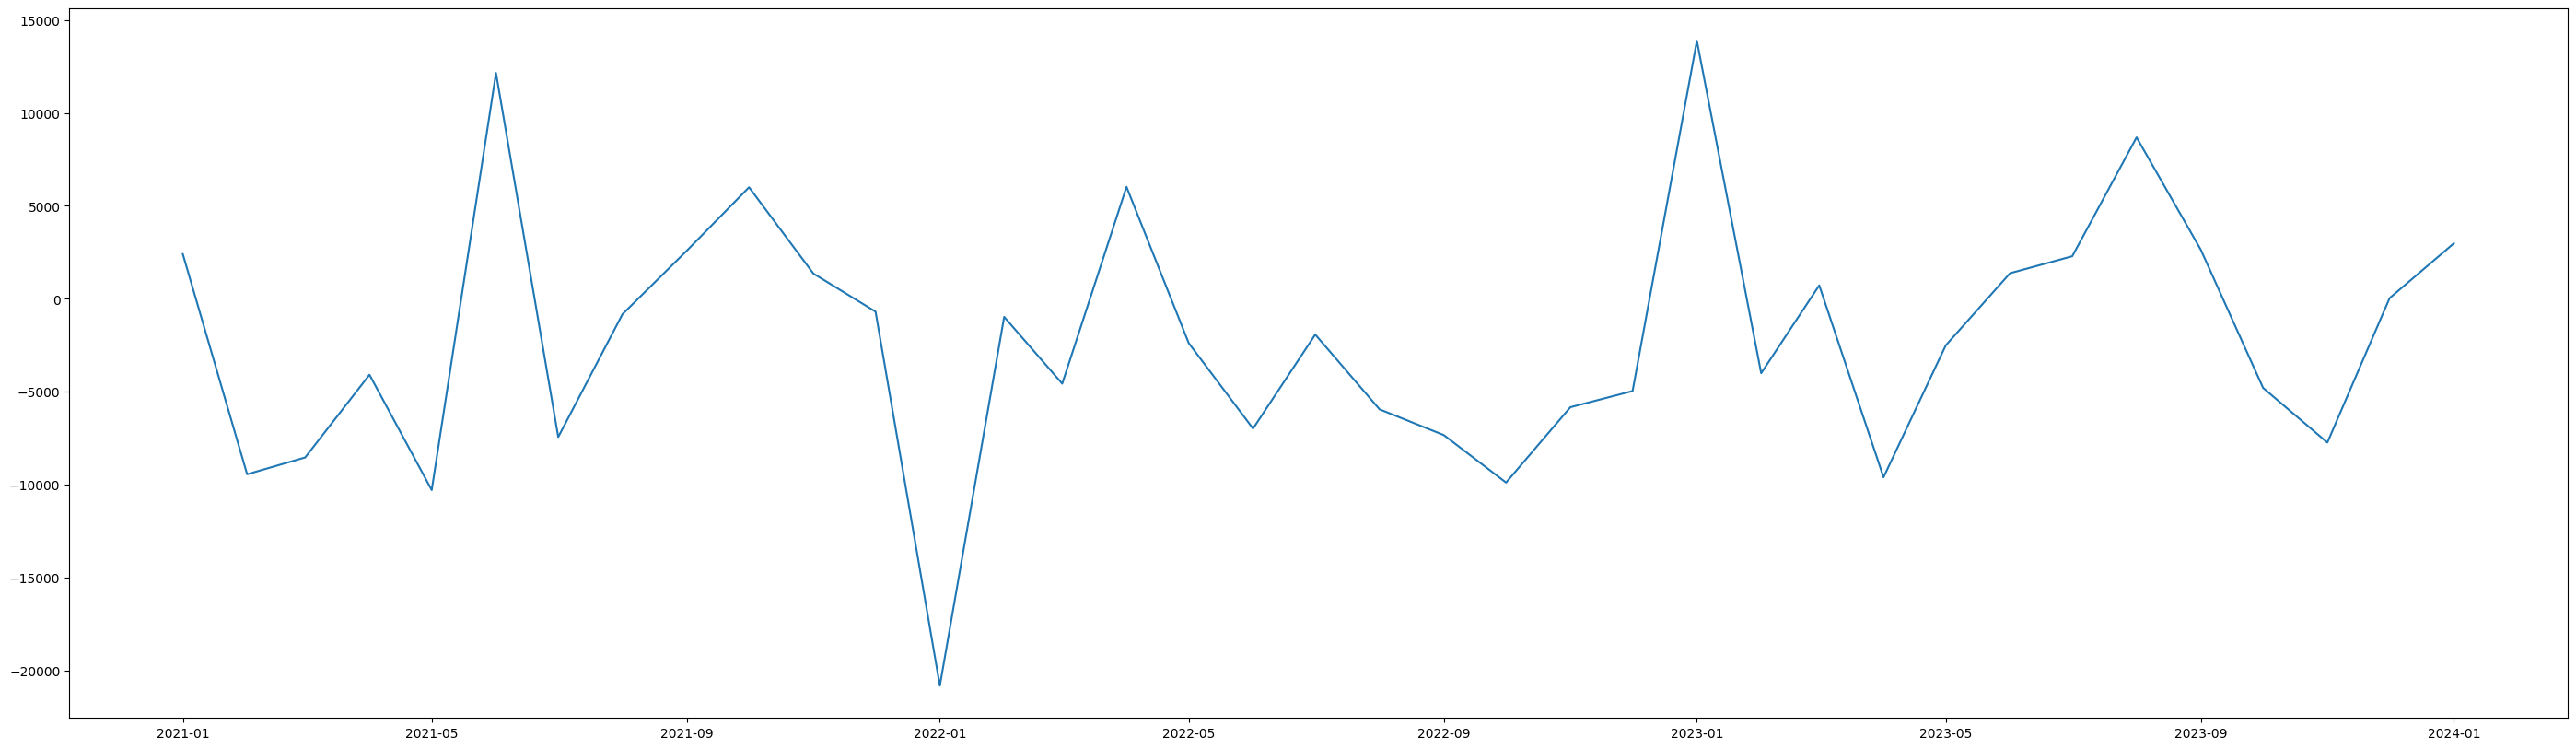

In [72]:
plt.figure(figsize=(35,10))
plt.plot(exp_model_fit_ce.resid)

Observaciones

Se observa un comportamiento aleatorio en los residuos, lo que implica que no hay patrones presentes. Esto sugiere que el modelo entrenado ha capturado adecuadamente las tendencias y estacionalidades relevantes de los datos.

### 4.1.3) Hiperparámetros para ExponentialSmoothing

In [73]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

In [74]:
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train_ce, test_ce, abg)

[0.1, 0.1, 0.1, 15804.87]
[0.1, 0.1, 0.3, 14196.09]
[0.1, 0.1, 0.5, 12306.55]
[0.1, 0.1, 0.7, 9580.1]
[0.1, 0.1, 0.9, 5795.12]
[0.1, 0.3, 0.1, 4803.9]
[0.1, 0.3, 0.3, 4175.06]
[0.1, 0.3, 0.5, 3687.81]
[0.1, 0.3, 0.7, 4910.57]
[0.1, 0.3, 0.9, 5778.74]
[0.1, 0.5, 0.1, 3329.5]
[0.1, 0.5, 0.3, 4481.84]
[0.1, 0.5, 0.5, 5963.33]
[0.1, 0.5, 0.7, 6863.56]
[0.1, 0.5, 0.9, 6496.69]
[0.1, 0.7, 0.1, 6338.61]
[0.1, 0.7, 0.3, 8913.86]
[0.1, 0.7, 0.5, 10175.14]
[0.1, 0.7, 0.7, 9656.69]
[0.1, 0.7, 0.9, 7874.32]
[0.1, 0.9, 0.1, 13183.75]
[0.1, 0.9, 0.3, 16669.41]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


[0.1, 0.9, 0.5, 16515.45]
[0.1, 0.9, 0.7, 14728.13]
[0.1, 0.9, 0.9, 12545.86]
[0.3, 0.1, 0.1, 7226.2]
[0.3, 0.1, 0.3, 7940.84]
[0.3, 0.1, 0.5, 8740.68]
[0.3, 0.1, 0.7, 9087.33]
[0.3, 0.1, 0.9, 8578.27]
[0.3, 0.3, 0.1, 6780.16]
[0.3, 0.3, 0.3, 7920.75]
[0.3, 0.3, 0.5, 8592.33]
[0.3, 0.3, 0.7, 8034.31]
[0.3, 0.3, 0.9, 6355.99]
[0.3, 0.5, 0.1, 7322.48]
[0.3, 0.5, 0.3, 6574.8]
[0.3, 0.5, 0.5, 4900.9]
[0.3, 0.5, 0.7, 3367.77]
[0.3, 0.5, 0.9, 3209.8]
[0.3, 0.7, 0.1, 6196.59]
[0.3, 0.7, 0.3, 4154.31]
[0.3, 0.7, 0.5, 2905.45]
[0.3, 0.7, 0.7, 6439.68]
[0.3, 0.7, 0.9, 10061.04]
[0.3, 0.9, 0.1, 5469.6]
[0.3, 0.9, 0.3, 2849.34]
[0.3, 0.9, 0.5, 7923.03]
[0.3, 0.9, 0.7, 13981.95]
[0.3, 0.9, 0.9, 16748.35]
[0.5, 0.1, 0.1, 6042.88]
[0.5, 0.1, 0.3, 5729.61]
[0.5, 0.1, 0.5, 4918.12]
[0.5, 0.1, 0.7, 4799.88]
[0.5, 0.1, 0.9, 5743.66]
[0.5, 0.3, 0.1, 5221.38]
[0.5, 0.3, 0.3, 4202.11]
[0.5, 0.3, 0.5, 4030.76]
[0.5, 0.3, 0.7, 6153.85]
[0.5, 0.3, 0.9, 8591.17]
[0.5, 0.5, 0.1, 4900.6]
[0.5, 0.5, 0.3, 3755.9]
[

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


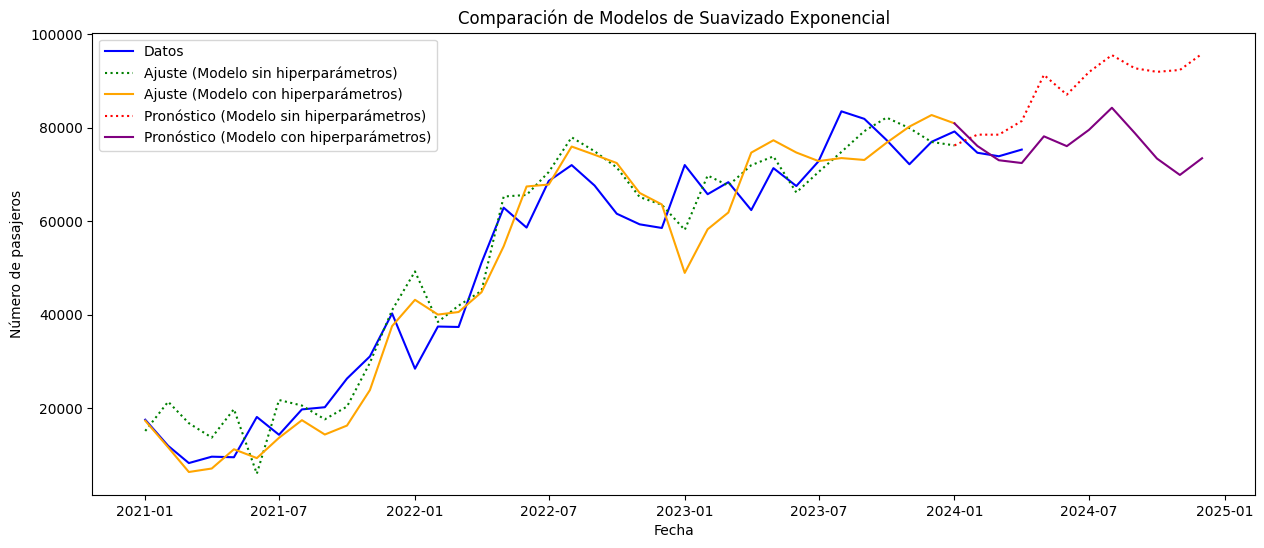

In [75]:
# Entrenar el modelo de suavizado exponencial triplano con hiperparámetros
final_tes_model = ExponentialSmoothing(
    train_ce,
    trend="add",
    seasonal="add",
    seasonal_periods=12
).fit(
    smoothing_level=best_alpha,
    smoothing_trend=best_beta,
    smoothing_seasonal=best_gamma
)

# Obtener la fecha de inicio y fin del pronóstico
forecast_start_date_hp = train_ce.index[-1] + pd.DateOffset(months=0)  # Comienza el mismo mes que en train_ce
forecast_end_date_hp = forecast_start_date_hp + pd.DateOffset(months=11)  # Cubre un período de 12 meses

# Generar el pronóstico
y_pred_hp = final_tes_model.predict(start=forecast_start_date_hp, end=forecast_end_date_hp)

# Visualizar los datos, ajuste del modelo sin hiperparámetros, pronóstico del modelo sin hiperparámetros y pronóstico del modelo con hiperparámetros
plt.figure(figsize=(15, 6))
plt.plot(df_final_mensual_entrenamiento.index, df_final_mensual_entrenamiento['pasajeros'], label='Datos', color='blue')
plt.plot(train_ce.index, exp_model_fit_ce.fittedvalues, label='Ajuste (Modelo sin hiperparámetros)', color='green', linestyle=":")
plt.plot(train_ce.index, final_tes_model.fittedvalues, label='Ajuste (Modelo con hiperparámetros)', color='orange')
plt.plot(forecast_ce.index, forecast_ce, label='Pronóstico (Modelo sin hiperparámetros)', color='red', linestyle=":")
plt.plot(y_pred_hp.index, y_pred_hp, label='Pronóstico (Modelo con hiperparámetros)', color='purple')
plt.title('Comparación de Modelos de Suavizado Exponencial')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.legend()
plt.show()

#### Analizamos métricas de performance

In [76]:
train_forecast_hp = final_tes_model.predict(start=0, end=36)
test_forecast_hp = final_tes_model.predict(start=36, end=40)

test_hp = df_final_mensual_entrenamiento[-5:]

print('RMSE train: ', np.sqrt(mean_squared_error(train_ce, train_forecast_hp)))
print('RMSE test: ', np.sqrt(mean_squared_error(test_hp, test_forecast_hp)))
print('MAE train: ', mean_absolute_error(train_ce, train_forecast_hp))
print('MAE test: ', mean_absolute_error(test_hp, test_forecast_hp))

RMSE train:  7545.160727664677
RMSE test:  2755.032407672604
MAE train:  5933.333140737616
MAE test:  2588.3587890229655


#### Analizamos residuos

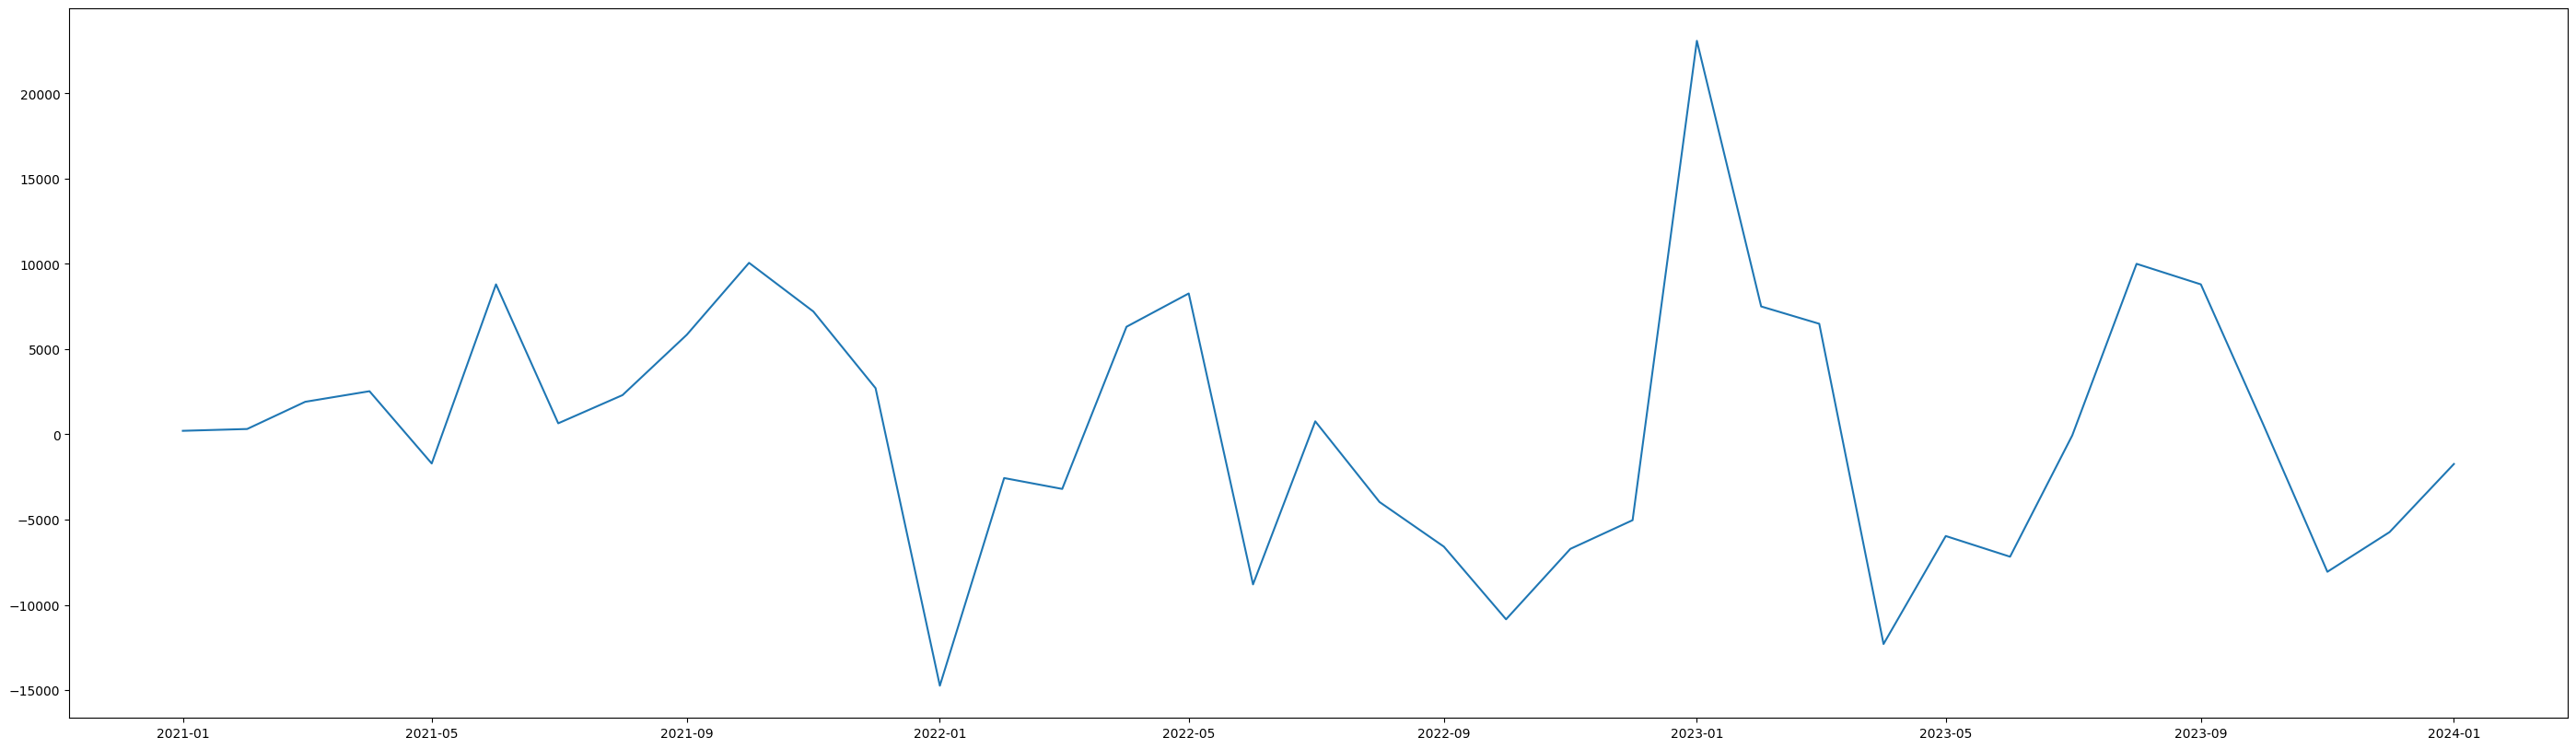

In [77]:
plt.figure(figsize=(35,10))
plt.plot(final_tes_model.resid)

Observaciones

Se observa un comportamiento aleatorio en los residuos, lo que implica que no hay patrones presentes. Esto sugiere que el modelo entrenado ha capturado adecuadamente las tendencias y estacionalidades relevantes de los datos.



## 4.2) Entrenamos con SARIMAX

En este modelo podemos sumar las dummies al análisis.

### 4.2.1) Buscamos Hiperparámetros para SARIMAX

In [78]:
ts = pd.Series(df_final_mensual_entrenamiento['pasajeros'])
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = [12]  # Para datos mensuales

mejor_modelo = busqueda_sarimax(ts, p, d, q, P, D, Q, s)
print("Mejores parámetros del modelo SARIMAX:", mejor_modelo)

SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:991.8897864898206
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:967.5600560810187
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:656.9946753369181
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:650.2700575381717
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:954.3096835613983
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:946.5751145417796
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:669.7946638458172
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:644.9740188718406
SARIMAX(0, 0, 1)x(0, 0, 0, 12) - AIC:970.273608758418
SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC:970.2198276831314
SARIMAX(0, 0, 1)x(0, 1, 0, 12) - AIC:637.6097136976055
SARIMAX(0, 0, 1)x(0, 1, 1, 12) - AIC:644.4264135333543
SARIMAX(0, 0, 1)x(1, 0, 0, 12) - AIC:969.759782973954
SARIMAX(0, 0, 1)x(1, 0, 1, 12) - AIC:971.7540229817009
SARIMAX(0, 0, 1)x(1, 1, 0, 12) - AIC:643.8859891377431
SARIMAX(0, 0, 1)x(1, 1, 1, 12) - AIC:645.4253327868827
SARIMAX(0, 0, 2)x(0, 0, 0, 12) - AIC:970.1435906705699
SARIMAX(0, 0, 2)x(0, 0, 1, 12) - AIC:971.7093443554058
SARIMAX(0, 0

### 4.2.2) Con hiperparámetros, estacionalidad y sin dummies

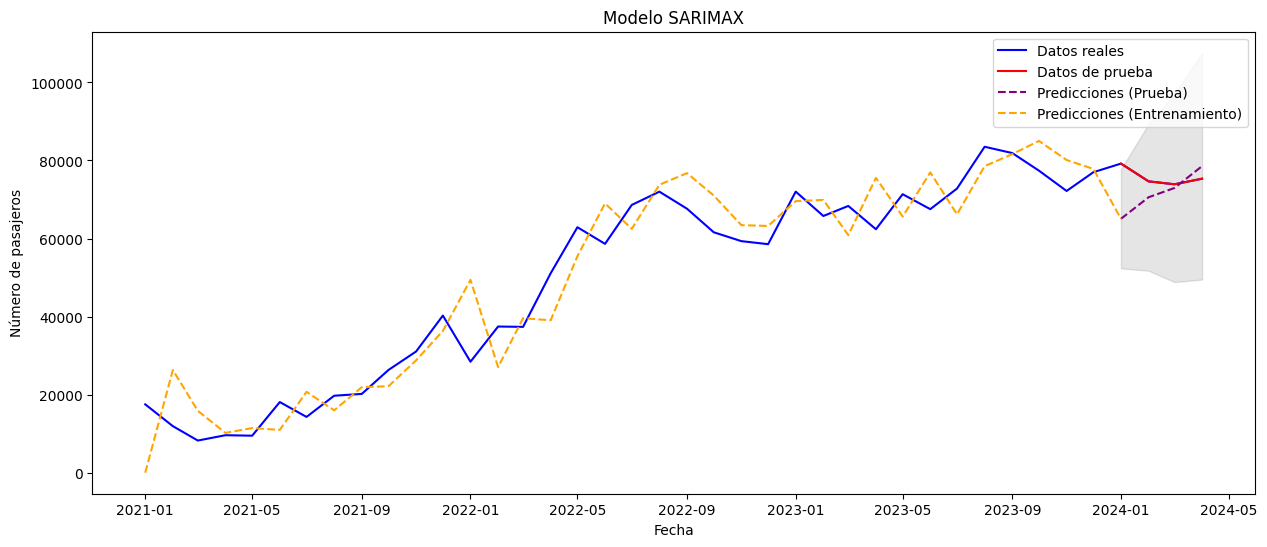

In [79]:
# Guardar parámetros obtenidos en una variable
mejores_params = mejor_modelo['params']

# Dividir los datos: los primeros 36 meses para entrenamiento, el resto para prueba
train_sm = df_final_mensual_entrenamiento.iloc[:36]
test_sm = df_final_mensual_entrenamiento.iloc[36:48]

# Ajustar el modelo SARIMAX en el conjunto de entrenamiento
model_sm = SARIMAX(train_sm['pasajeros'], order=mejores_params[0], seasonal_order=mejores_params[1])
results_sm = model_sm.fit()

# Hacer predicciones en el conjunto de prueba
predictions_sm = results_sm.get_forecast(steps=len(test_sm))
predicted_mean_sm = predictions_sm.predicted_mean
conf_int_sm = predictions_sm.conf_int()

# Hacer predicciones en el conjunto de entrenamiento
train_predictions_sm = results_sm.predict(start=train_sm.index[0], end=train_sm.index[-1])

train_predictions_sm_to_plot = results_sm.predict(start=train_sm.index[0], end=test_sm.index[0]) # se crea para que grafique completo el entrenamiento

# Graficar los datos originales, las predicciones y el intervalo de confianza
plt.figure(figsize=(15, 6))
plt.plot(df_final_mensual_entrenamiento.index, df_final_mensual_entrenamiento['pasajeros'], label='Datos reales', color='blue')
plt.plot(test_sm.index, test_sm['pasajeros'], label='Datos de prueba', color='red')
plt.plot(predicted_mean_sm.index, predicted_mean_sm, label='Predicciones (Prueba)', linestyle='--', color='purple')
plt.plot(train_predictions_sm_to_plot.index, train_predictions_sm_to_plot, label='Predicciones (Entrenamiento)', linestyle='--', color='orange')
plt.fill_between(predicted_mean_sm.index, conf_int_sm.iloc[:, 0], conf_int_sm.iloc[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title('Modelo SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.show()

#### Analizamos métricas de performance

In [80]:
# Imprimir el resumen del modelo ajustado
print(results_sm.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          pasajeros   No. Observations:                   36
Model:             SARIMAX(0, 2, 1)x(1, 1, 1, 12)   Log Likelihood                -226.392
Date:                            Thu, 23 May 2024   AIC                            460.784
Time:                                    13:36:38   BIC                            465.148
Sample:                                01-01-2021   HQIC                           461.812
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9119      0.234     -3.891      0.000      -1.371      -0.453
ar.S.L12      -0.9965      0.058   

In [81]:
mae_test = mean_absolute_error(test_sm['pasajeros'], predicted_mean_sm)
rmse_test = np.sqrt(mean_squared_error(test_sm['pasajeros'], predicted_mean_sm))
mae_train = mean_absolute_error(train_sm['pasajeros'], train_predictions_sm)
rmse_train = np.sqrt(mean_squared_error(train_sm['pasajeros'], train_predictions_sm))

print(f'RMSE entrenamiento: {rmse_train}')
print(f'RMSE prueba: {rmse_test}')
print(f'Error Medio Absoluto prueba (MAE): {mae_test}')
print(f'Error Medio Absoluto entrenamiento (MAE): {mae_train}')

RMSE entrenamiento: 8163.809948371856
RMSE prueba: 7547.374644134021
Error Medio Absoluto prueba (MAE): 5596.682913572746
Error Medio Absoluto entrenamiento (MAE): 6687.0084349098


#### Analizamos residuos

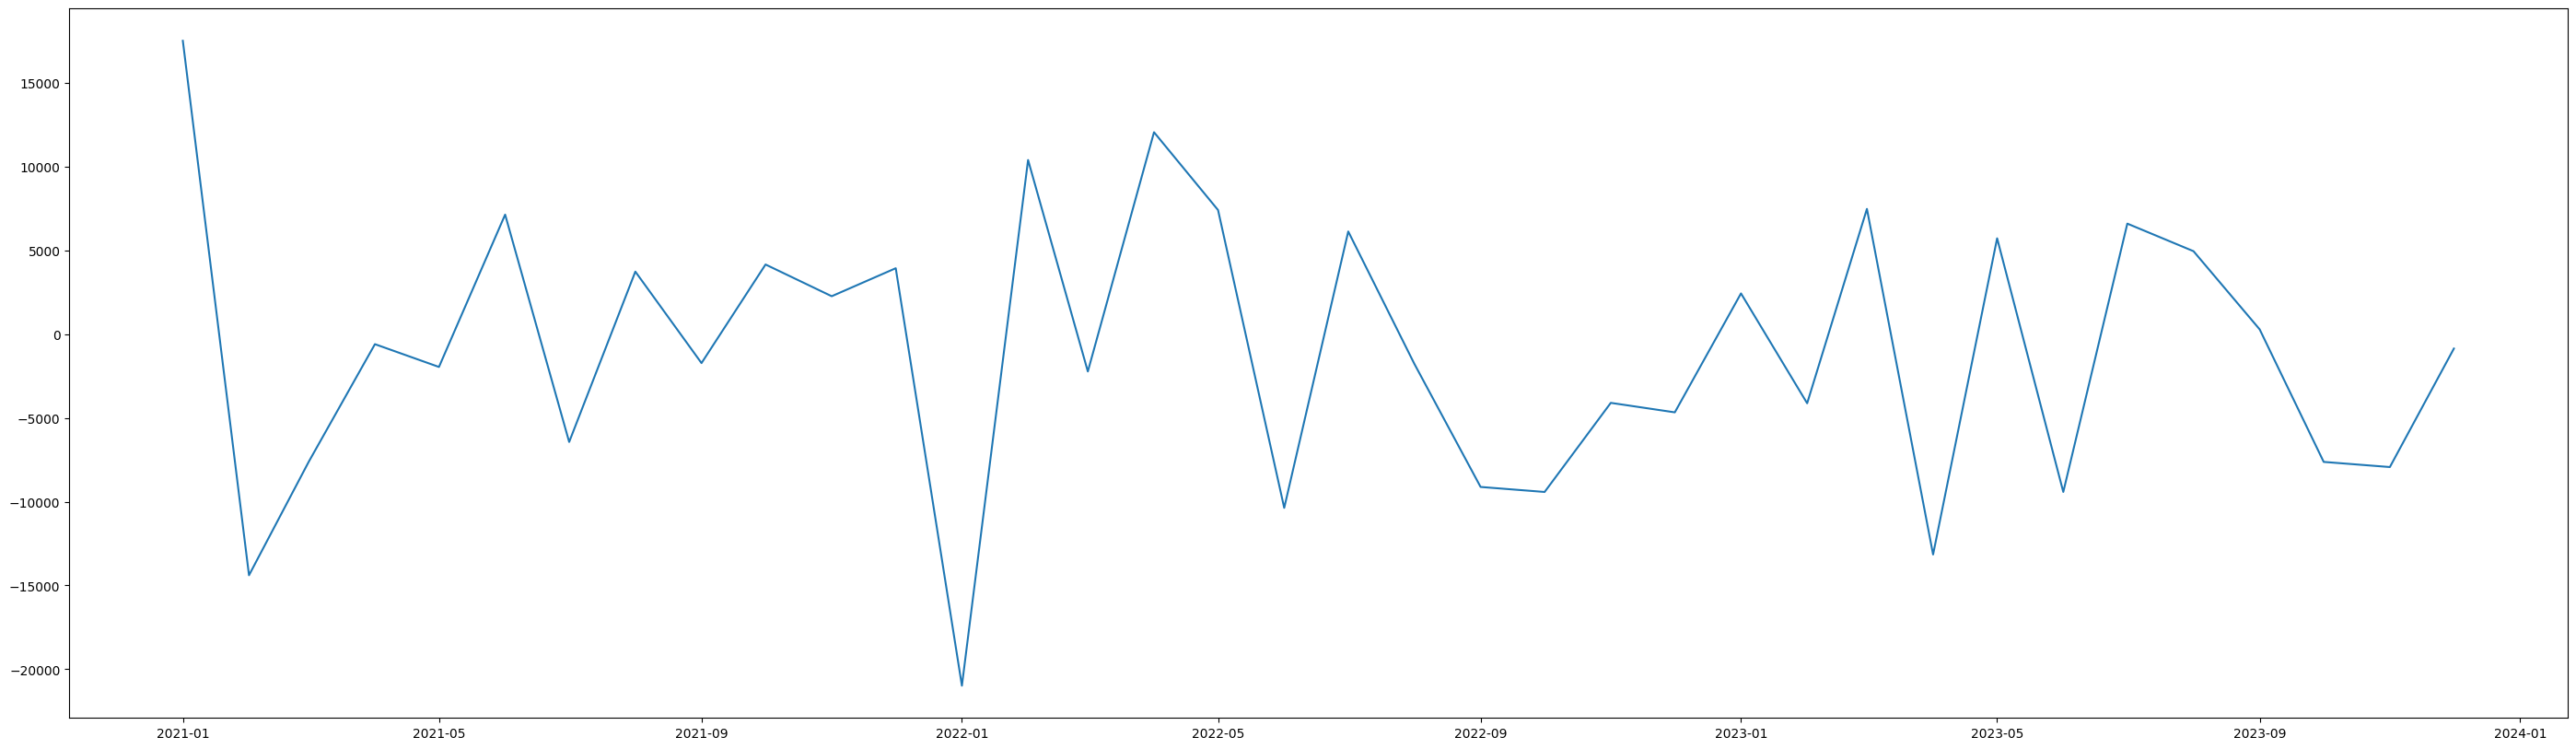

In [82]:
plt.figure(figsize=(35,10))
plt.plot(results_sm.resid)

Observaciones

Se observa un comportamiento random en los residuos, lo que implica que no hay patrones presentes. Esto sugiere que el modelo entrenado ha capturado las tendencias y estacionalidades relevantes de los datos.

### 4.2.3) Buscamos hiperparámetros con gridsearchCV en un pipeline

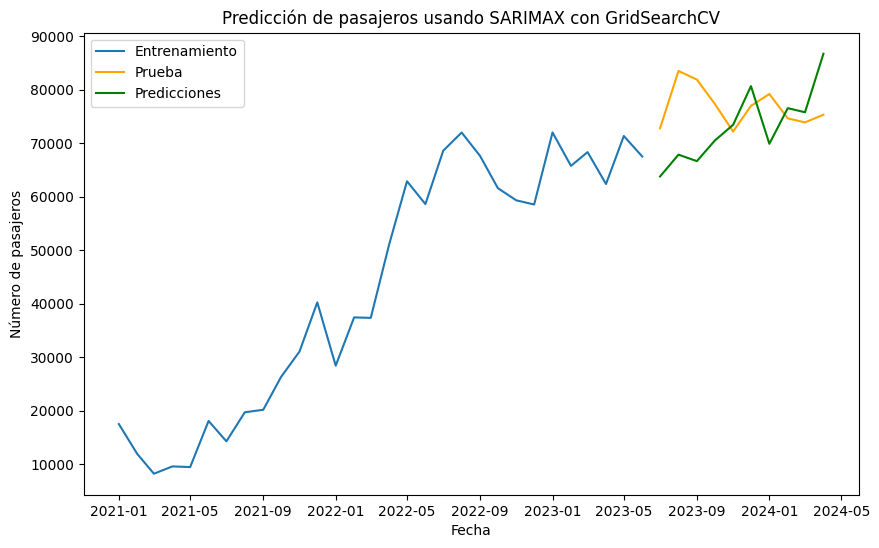

mae 7626.404329932755
rmse 9192.312371327174
Mejores parámetros: {'fit__kw_args': {'order': (1, 0, 0), 'seasonal_order': (1, 1, 1, 12)}}


In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Dividir los datos: los primeros 30 meses para entrenamiento, el resto para prueba
train = df_final_mensual_entrenamiento.iloc[:30]
test = df_final_mensual_entrenamiento.iloc[30:48]

# Función para ajustar SARIMAX
def sarimax_fit(X, y=None, order=(1, 0, 0), seasonal_order=(1, 1, 1, 12)):
    model = SARIMAX(X, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    return results

# Función para predecir usando un modelo ajustado de SARIMAX
def sarimax_predict(results, steps):
    forecast = results.get_forecast(steps=steps)
    return forecast.predicted_mean

# Función para hacer la predicción en el pipeline
def predict_with_sarimax(X, order=(1, 0, 0), seasonal_order=(1, 1, 1, 12)):
    model = sarimax_fit(X, order=order, seasonal_order=seasonal_order)
    return sarimax_predict(model, steps=len(X))

# Crear transformadores con FunctionTransformer
fit_transformer = FunctionTransformer(sarimax_fit, kw_args={'order': (1, 0, 0), 'seasonal_order': (1, 1, 1, 12)}, validate=False)
predict_transformer = FunctionTransformer(predict_with_sarimax, kw_args={'order': (1, 0, 0), 'seasonal_order': (1, 1, 1, 12)}, validate=False)

# Definir el pipeline
pipeline = Pipeline([
    ('fit', fit_transformer),
    ('predict', predict_transformer)
])

# Definir el grid de parámetros
param_grid = {
    'fit__kw_args': [{'order': (1, 0, 0), 'seasonal_order': (1, 1, 1, 12)},
                     {'order': (1, 1, 0), 'seasonal_order': (1, 0, 1, 12)},
                     {'order': (0, 1, 1), 'seasonal_order': (0, 1, 1, 12)}]
}

# Definir el cross-validator
tscv = TimeSeriesSplit(n_splits=3)

# Definir el GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Ajustar el GridSearchCV
grid_search.fit(train['pasajeros'].values.reshape(-1, 1))

# Mejor modelo encontrado
best_params = grid_search.best_params_
order = best_params['fit__kw_args']['order']
seasonal_order = best_params['fit__kw_args']['seasonal_order']

# Ajustar el mejor modelo en los datos de entrenamiento completos
best_model_results = sarimax_fit(train['pasajeros'], order=order, seasonal_order=seasonal_order)

# Hacer predicciones en el conjunto de prueba
predicted_mean = sarimax_predict(best_model_results, steps=len(test))

# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['pasajeros'], label='Entrenamiento')
plt.plot(test.index, test['pasajeros'], label='Prueba', color='orange')
plt.plot(test.index, predicted_mean, label='Predicciones', color='green')
plt.legend()
plt.title('Predicción de pasajeros usando SARIMAX con GridSearchCV')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.show()

mae = mean_absolute_error(test['pasajeros'], predicted_mean)
print('mae', mae)

rmse = np.sqrt(mean_squared_error(test['pasajeros'], predicted_mean))
print('rmse', rmse)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", best_params)

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

class SarimaxFit(BaseEstimator, TransformerMixin):
    def __init__(self, order=(1, 0, 0), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.results_ = None

    def fit(self, X, y=None):
        self.model_ = SARIMAX(X, order=self.order, seasonal_order=self.seasonal_order)
        self.results_ = self.model_.fit(disp=False)
        return self

    def transform(self, X, y=None):
        return self

    def get_results(self):
        return self.results_

class SarimaxPredict(BaseEstimator, TransformerMixin):
    def __init__(self, steps=None):
        self.steps = steps
        self.forecast_ = None

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.steps is None:
            self.steps = len(X)
        self.forecast_ = self.results_.get_forecast(steps=self.steps)
        return self.forecast_.predicted_mean


# Pipeline que ajusta y predice usando SARIMAX
sarimax_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sarimax_fit', SarimaxFit()),
    ('sarimax_predict', SarimaxPredict())
])

param_grid = {
    'sarimax_fit__order': [(1, 0, 0), (1, 1, 0), (2, 1, 0)],
    'sarimax_fit__seasonal_order': [(1, 1, 1, 12), (1, 0, 1, 12)],
    'sarimax_predict__steps': [10, 20, 30]
}

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Configuración de la validación cruzada para series temporales
tscv = TimeSeriesSplit(n_splits=5)

# Configuración de GridSearchCV
grid_search = GridSearchCV(sarimax_pipeline, param_grid, cv=tscv, scoring='neg_mean_squared_error')

# Datos de ejemplo (reemplaza con tus datos reales)
X = np.random.rand(100)  # Serie temporal con 100 puntos

X = y.reshape(-1, 1)

# Ajustar el grid search
grid_search.fit(X)

# Mejor configuración de parámetros y mejor puntaje
print("Mejores parámetros encontrados: ", grid_search.best_params_)
print("Mejor puntaje (neg MSE): ", grid_search.best_score_)
print("Mejor puntaje (MSE): ", -grid_search.best_score_)


NameError: name 'y' is not defined

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

train = df_monthly.iloc[:30]
test = df_monthly.iloc[30:48]

# Función de ajuste
def sarimax_fit(X, y=None, order=(1, 0, 0), seasonal_order=(1, 1, 1, 12)):
    model = SARIMAX(X, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    return results

# Función de prediccion
def sarimax_predict(results, steps):
    forecast = results.get_forecast(steps=steps)
    return forecast.predicted_mean

# Función de prediccion en el pipeline
def predict_with_sarimax(X, order=(1, 0, 0), seasonal_order=(1, 1, 1, 12)):
    model = sarimax_fit(X, order=order, seasonal_order=seasonal_order)
    return sarimax_predict(model, steps=len(X))

fit_transformer = FunctionTransformer(sarimax_fit, kw_args={'order': (1, 0, 0), 'seasonal_order': (1, 1, 1, 12)}, validate=False)
predict_transformer = FunctionTransformer(predict_with_sarimax, kw_args={'order': (1, 0, 0), 'seasonal_order': (1, 1, 1, 12)}, validate=False)

# Definir el pipeline
pipeline = Pipeline([
    ('fit', fit_transformer),
    ('predict', predict_transformer)
])


order_1 = (1, 0, 0)
order_2 = (1, 1, 0)
order_3 = (0, 1, 1)

# Definir el grid de parámetros
param_grid = {
    'fit__kw_args': [{'order': order_1, 'seasonal_order': (1, 1, 1, 12)},
                     {'order': order_2, 'seasonal_order': (1, 0, 1, 12)},
                     {'order': order_3, 'seasonal_order': (0, 1, 1, 12)}]
}

tscv = TimeSeriesSplit(n_splits=3)

# Se define un GridSearchCV

scoring_gs_cv = 'neg_mean_squared_error'
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring= scoring_gs_cv)

# Ajustar el GridSearchCV
grid_search.fit(train['pasajeros'].values.reshape(-1, 1))

# Mejor modelo encontrado
best_params = grid_search.best_params_
order = best_params['fit__kw_args']['order']
seasonal_order = best_params['fit__kw_args']['seasonal_order']

# Ajustar el mejor modelo en los datos de entrenamiento completos
best_model_results = sarimax_fit(train['pasajeros'], order=order, seasonal_order=seasonal_order)

# Se hace el predict
predicted_mean = sarimax_predict(best_model_results, steps=len(test))

# Indicadores de error
mae = mean_absolute_error(test['pasajeros'], predicted_mean)
print('mae', mae)

rmse = np.sqrt(mean_squared_error(test['pasajeros'], predicted_mean))
print('rmse', rmse)

# Mejores parámetros encontrados
print("Mejores parametros:", best_params)

# Best model
print("Mejores modelo:", grid_search.best_estimator_)


# Visualizar los resultados
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['pasajeros'], label='Entrenamiento')
plt.plot(test.index, test['pasajeros'], label='Prueba', color='orange')
plt.plot(test.index, predicted_mean, label='Predicciones', color='green')
plt.legend()
plt.title('Predicción de pasajeros usando SARIMAX con GridSearchCV')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.show()


## 5. Análisis pronóstico de pasajeros y precio

**Clasificación de precios de boletos:**

Se determina la cantidad de pasajeros por año para cada mes. Según la cantidad máxima y mínima de ese año, definimos umbrales que nos permitan definir si la demanda es baja, media o alta. Esa demanda la extrapolamos a un precio bajo, medio o alto.

## 6. Conclusiones

Nuestro objetivo es realizar pronósticos de vuelos desde Argentina a Madrid, con la finalidad de predecir cuándo sería más barato viajar en función de la cantidad de pasajeros que viajarían. En este contexto, las métricas de error son cruciales para asegurar la precisión y confiabilidad de nuestras predicciones.

Después de evaluar las métricas de performance de los modelos entrenados, hemos decidido avanzar con la utilización del algoritmo Exponential Smoothing debido a su destacada performance. A continuación, se presentan las métricas obtenidas para este modelo:

* RMSE (Root Mean Squared Error) en el conjunto de entrenamiento: 7545.16
* RMSE en el conjunto de prueba: 2755.03
* MAE (Mean Absolute Error) en el conjunto de entrenamiento: 5933.33
* MAE en el conjunto de prueba: 2588.36

Las razones principales para elegir el modelo de Exponential Smoothing son las siguientes:

Precisión en el conjunto de prueba: El modelo de Exponential Smoothing ha demostrado tener los valores de RMSE y MAE más bajos en el conjunto de prueba comparado con los otros modelos entrenados. Esto indica que el modelo tiene una mejor capacidad para generalizar y predecir datos no vistos previamente.

Consistencia en las métricas: Los valores de RMSE y MAE en el conjunto de entrenamiento también son relativamente bajos, lo que sugiere que el modelo está bien ajustado a los datos de entrenamiento sin sobreajustarse.

Dado nuestro objetivo de predecir la demanda de vuelos para identificar períodos de menor costo de viaje, la precisión en las predicciones es fundamental. Las métricas de error, especialmente en el conjunto de prueba, son indicativas de la capacidad del modelo para hacer predicciones precisas. Un error más bajo en el conjunto de prueba sugiere que el modelo de Exponential Smoothing es más adecuado para realizar pronósticos fiables sobre la cantidad de pasajeros y, por ende, sobre los períodos más económicos para viajar.